# Fashion-MNIST GAN example

## Library import

In [0]:
from __future__ import print_function, division

from keras.datasets import fashion_mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU

import matplotlib.pyplot as plt
import sys
import numpy as np

## Dataset Analysis

In [0]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [23]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [0]:
index2label = {
0: 	'T-shirt/top',
1: 	'Trouser',
2: 	'Pullover',
3: 	'Dress',
4: 	'Coat',
5: 	'Sanda',
6: 	'Shirt',
7: 	'Sneaker',
8: 	'Bag',
9: 	'Ankle boot',
}

display image snippet

In [0]:
def display_image(x,y,i):
  label= index2label.get(y[i])
  image = x[1].reshape([28,28])
  plt.title('Image: {} Label: {}'.format(i,label))
  plt.imshow(image, cmap='gray')
  plt.show()

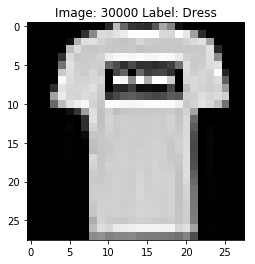

In [39]:
display_image(x_train, y_train, 30000)

In [0]:
display_image(x_test, y_test, 30000)

## Model definition

In [0]:
class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        #model.add(Dense(2048))
        #model.add(LeakyReLU(alpha=0.2))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        #model.add(Dense(512))
        #model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = fashion_mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        #fig.savefig("images/%d.png" % epoch)
        plt.show()
        plt.close()

In [4]:
gan = GAN()




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_____________________________________________

## Model Training

4423680/4422102 [==============================] - 0s 0us/step


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.913547, acc.: 50.00%] [G loss: 0.930964]


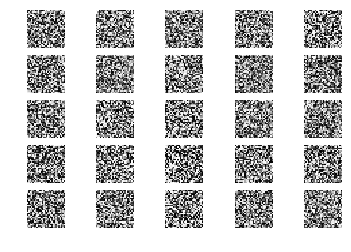

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 [D loss: 0.418045, acc.: 90.62%] [G loss: 0.937002]
2 [D loss: 0.317613, acc.: 85.94%] [G loss: 1.084084]
3 [D loss: 0.270510, acc.: 96.88%] [G loss: 1.201128]
4 [D loss: 0.225428, acc.: 95.31%] [G loss: 1.319125]
5 [D loss: 0.180559, acc.: 98.44%] [G loss: 1.412234]
6 [D loss: 0.165499, acc.: 100.00%] [G loss: 1.486743]
7 [D loss: 0.159006, acc.: 100.00%] [G loss: 1.629766]
8 [D loss: 0.130106, acc.: 100.00%] [G loss: 1.560714]
9 [D loss: 0.130183, acc.: 100.00%] [G loss: 1.756788]
10 [D loss: 0.104710, acc.: 100.00%] [G loss: 1.844148]
11 [D loss: 0.112489, acc.: 100.00%] [G loss: 2.021524]
12 [D loss: 0.100046, acc.: 100.00%] [G loss: 1.983947]
13 [D loss: 0.100420, acc.: 100.00%] [G loss: 2.009149]
14 [D loss: 0.071056, acc.: 100.00%] [G loss: 2.049316]
15 [D loss: 0.084985, acc.: 100.00%] [G loss: 2.223077]
16 [D loss: 0.085514, acc.: 98.44%] [G loss: 2.257240]
17 [D loss: 0.072533, acc.: 100.00%] [G loss: 2.233579]
18 [D loss: 0.071072, acc.: 100.00%] [G loss: 2.361398]
19 [D l

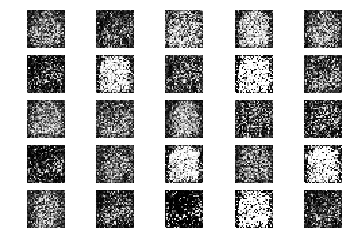

201 [D loss: 0.289718, acc.: 90.62%] [G loss: 3.427655]
202 [D loss: 0.257134, acc.: 90.62%] [G loss: 3.811396]
203 [D loss: 0.265312, acc.: 92.19%] [G loss: 3.751318]
204 [D loss: 0.445111, acc.: 76.56%] [G loss: 2.857608]
205 [D loss: 0.146816, acc.: 95.31%] [G loss: 3.115036]
206 [D loss: 0.134182, acc.: 95.31%] [G loss: 3.432653]
207 [D loss: 0.184262, acc.: 92.19%] [G loss: 3.472831]
208 [D loss: 0.292333, acc.: 92.19%] [G loss: 3.525152]
209 [D loss: 0.431212, acc.: 76.56%] [G loss: 3.024839]
210 [D loss: 0.167470, acc.: 95.31%] [G loss: 3.640234]
211 [D loss: 0.624550, acc.: 73.44%] [G loss: 2.809413]
212 [D loss: 0.288572, acc.: 89.06%] [G loss: 3.304237]
213 [D loss: 0.586337, acc.: 76.56%] [G loss: 2.698094]
214 [D loss: 0.299595, acc.: 82.81%] [G loss: 3.911032]
215 [D loss: 0.342873, acc.: 84.38%] [G loss: 3.190771]
216 [D loss: 0.240741, acc.: 89.06%] [G loss: 3.002057]
217 [D loss: 0.344036, acc.: 85.94%] [G loss: 3.627381]
218 [D loss: 0.333942, acc.: 87.50%] [G loss: 3.

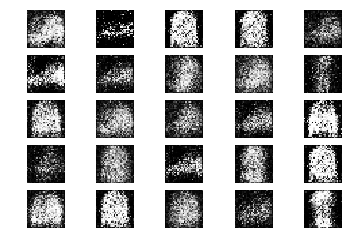

401 [D loss: 0.533060, acc.: 76.56%] [G loss: 1.203234]
402 [D loss: 0.677803, acc.: 60.94%] [G loss: 1.150774]
403 [D loss: 0.611168, acc.: 71.88%] [G loss: 1.044594]
404 [D loss: 0.601971, acc.: 65.62%] [G loss: 0.988680]
405 [D loss: 0.487375, acc.: 82.81%] [G loss: 1.178861]
406 [D loss: 0.630348, acc.: 67.19%] [G loss: 1.172073]
407 [D loss: 0.603338, acc.: 62.50%] [G loss: 1.131467]
408 [D loss: 0.626996, acc.: 62.50%] [G loss: 1.070297]
409 [D loss: 0.623486, acc.: 65.62%] [G loss: 0.981852]
410 [D loss: 0.588892, acc.: 71.88%] [G loss: 1.052581]
411 [D loss: 0.637729, acc.: 56.25%] [G loss: 1.106880]
412 [D loss: 0.626149, acc.: 64.06%] [G loss: 1.111376]
413 [D loss: 0.609169, acc.: 64.06%] [G loss: 1.154585]
414 [D loss: 0.502468, acc.: 78.12%] [G loss: 1.175080]
415 [D loss: 0.519863, acc.: 71.88%] [G loss: 1.093444]
416 [D loss: 0.682401, acc.: 62.50%] [G loss: 1.040272]
417 [D loss: 0.642874, acc.: 62.50%] [G loss: 1.108304]
418 [D loss: 0.699361, acc.: 54.69%] [G loss: 1.

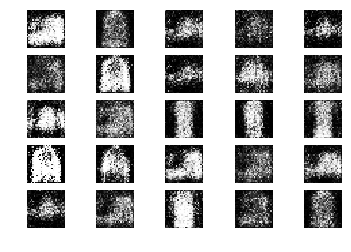

601 [D loss: 0.544408, acc.: 81.25%] [G loss: 0.988735]
602 [D loss: 0.641096, acc.: 68.75%] [G loss: 0.925745]
603 [D loss: 0.634979, acc.: 62.50%] [G loss: 0.968282]
604 [D loss: 0.629417, acc.: 65.62%] [G loss: 1.042838]
605 [D loss: 0.632570, acc.: 68.75%] [G loss: 0.926948]
606 [D loss: 0.650882, acc.: 57.81%] [G loss: 0.908938]
607 [D loss: 0.609442, acc.: 65.62%] [G loss: 0.887811]
608 [D loss: 0.599458, acc.: 73.44%] [G loss: 0.931939]
609 [D loss: 0.572837, acc.: 73.44%] [G loss: 0.974571]
610 [D loss: 0.565971, acc.: 75.00%] [G loss: 0.972789]
611 [D loss: 0.658922, acc.: 59.38%] [G loss: 0.901100]
612 [D loss: 0.578148, acc.: 68.75%] [G loss: 0.905910]
613 [D loss: 0.549238, acc.: 68.75%] [G loss: 0.903014]
614 [D loss: 0.631007, acc.: 64.06%] [G loss: 0.867703]
615 [D loss: 0.578581, acc.: 65.62%] [G loss: 0.902336]
616 [D loss: 0.593190, acc.: 65.62%] [G loss: 0.997474]
617 [D loss: 0.523658, acc.: 81.25%] [G loss: 1.036304]
618 [D loss: 0.585612, acc.: 73.44%] [G loss: 0.

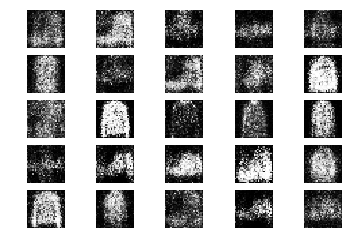

801 [D loss: 0.585825, acc.: 76.56%] [G loss: 0.801347]
802 [D loss: 0.614053, acc.: 60.94%] [G loss: 0.909089]
803 [D loss: 0.530124, acc.: 85.94%] [G loss: 0.898316]
804 [D loss: 0.598623, acc.: 68.75%] [G loss: 0.879650]
805 [D loss: 0.643505, acc.: 67.19%] [G loss: 0.863904]
806 [D loss: 0.590843, acc.: 67.19%] [G loss: 0.830403]
807 [D loss: 0.656977, acc.: 57.81%] [G loss: 0.900740]
808 [D loss: 0.686043, acc.: 56.25%] [G loss: 0.898865]
809 [D loss: 0.657297, acc.: 57.81%] [G loss: 0.962075]
810 [D loss: 0.646429, acc.: 60.94%] [G loss: 0.913582]
811 [D loss: 0.585633, acc.: 71.88%] [G loss: 0.937129]
812 [D loss: 0.623029, acc.: 57.81%] [G loss: 0.867599]
813 [D loss: 0.651440, acc.: 65.62%] [G loss: 0.910686]
814 [D loss: 0.626609, acc.: 68.75%] [G loss: 0.937044]
815 [D loss: 0.617359, acc.: 64.06%] [G loss: 0.907056]
816 [D loss: 0.652514, acc.: 57.81%] [G loss: 0.894590]
817 [D loss: 0.596307, acc.: 73.44%] [G loss: 0.872355]
818 [D loss: 0.628981, acc.: 64.06%] [G loss: 0.

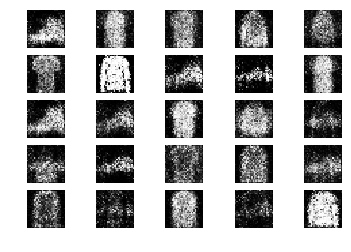

1001 [D loss: 0.637946, acc.: 59.38%] [G loss: 0.954559]
1002 [D loss: 0.662612, acc.: 59.38%] [G loss: 0.845092]
1003 [D loss: 0.555511, acc.: 76.56%] [G loss: 0.952232]
1004 [D loss: 0.658026, acc.: 60.94%] [G loss: 0.910853]
1005 [D loss: 0.623133, acc.: 67.19%] [G loss: 0.890454]
1006 [D loss: 0.634039, acc.: 59.38%] [G loss: 0.891540]
1007 [D loss: 0.639774, acc.: 60.94%] [G loss: 0.927720]
1008 [D loss: 0.642409, acc.: 56.25%] [G loss: 0.865593]
1009 [D loss: 0.635790, acc.: 65.62%] [G loss: 0.811167]
1010 [D loss: 0.620882, acc.: 65.62%] [G loss: 0.883735]
1011 [D loss: 0.604169, acc.: 73.44%] [G loss: 0.933190]
1012 [D loss: 0.594506, acc.: 71.88%] [G loss: 0.918054]
1013 [D loss: 0.676742, acc.: 68.75%] [G loss: 0.972830]
1014 [D loss: 0.573114, acc.: 68.75%] [G loss: 0.931478]
1015 [D loss: 0.604324, acc.: 68.75%] [G loss: 0.881771]
1016 [D loss: 0.648526, acc.: 64.06%] [G loss: 0.836659]
1017 [D loss: 0.671812, acc.: 59.38%] [G loss: 0.811475]
1018 [D loss: 0.596209, acc.: 7

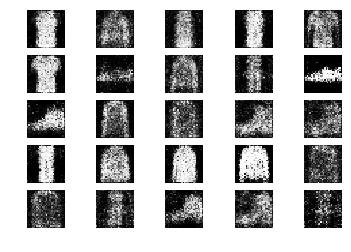

1201 [D loss: 0.634322, acc.: 60.94%] [G loss: 0.875337]
1202 [D loss: 0.559291, acc.: 76.56%] [G loss: 0.975038]
1203 [D loss: 0.659605, acc.: 56.25%] [G loss: 0.823419]
1204 [D loss: 0.659081, acc.: 57.81%] [G loss: 0.847763]
1205 [D loss: 0.643734, acc.: 64.06%] [G loss: 0.873768]
1206 [D loss: 0.562092, acc.: 75.00%] [G loss: 0.888357]
1207 [D loss: 0.607094, acc.: 70.31%] [G loss: 0.922914]
1208 [D loss: 0.653296, acc.: 60.94%] [G loss: 0.859460]
1209 [D loss: 0.614801, acc.: 64.06%] [G loss: 0.926065]
1210 [D loss: 0.602360, acc.: 68.75%] [G loss: 0.882602]
1211 [D loss: 0.601307, acc.: 65.62%] [G loss: 0.910878]
1212 [D loss: 0.629452, acc.: 64.06%] [G loss: 0.866012]
1213 [D loss: 0.646799, acc.: 60.94%] [G loss: 0.902027]
1214 [D loss: 0.627377, acc.: 60.94%] [G loss: 0.779195]
1215 [D loss: 0.630899, acc.: 62.50%] [G loss: 0.949769]
1216 [D loss: 0.585097, acc.: 65.62%] [G loss: 0.898401]
1217 [D loss: 0.620822, acc.: 64.06%] [G loss: 0.938263]
1218 [D loss: 0.647113, acc.: 6

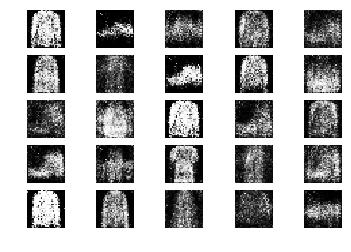

1401 [D loss: 0.580504, acc.: 76.56%] [G loss: 0.905874]
1402 [D loss: 0.653762, acc.: 56.25%] [G loss: 0.783678]
1403 [D loss: 0.545023, acc.: 78.12%] [G loss: 0.883924]
1404 [D loss: 0.608316, acc.: 65.62%] [G loss: 0.925411]
1405 [D loss: 0.617823, acc.: 60.94%] [G loss: 0.941178]
1406 [D loss: 0.608870, acc.: 62.50%] [G loss: 0.919003]
1407 [D loss: 0.640595, acc.: 64.06%] [G loss: 0.972910]
1408 [D loss: 0.669088, acc.: 64.06%] [G loss: 0.913431]
1409 [D loss: 0.662182, acc.: 62.50%] [G loss: 0.948206]
1410 [D loss: 0.658147, acc.: 59.38%] [G loss: 0.892941]
1411 [D loss: 0.643811, acc.: 60.94%] [G loss: 0.782574]
1412 [D loss: 0.615460, acc.: 62.50%] [G loss: 0.868940]
1413 [D loss: 0.599421, acc.: 76.56%] [G loss: 0.939482]
1414 [D loss: 0.594333, acc.: 65.62%] [G loss: 0.973845]
1415 [D loss: 0.610009, acc.: 75.00%] [G loss: 0.905993]
1416 [D loss: 0.609541, acc.: 67.19%] [G loss: 0.829871]
1417 [D loss: 0.656398, acc.: 57.81%] [G loss: 0.917674]
1418 [D loss: 0.647213, acc.: 5

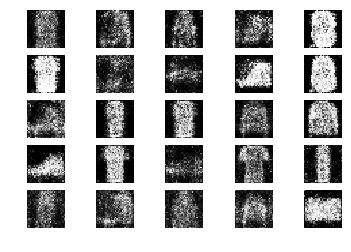

1601 [D loss: 0.617157, acc.: 68.75%] [G loss: 0.989761]
1602 [D loss: 0.639034, acc.: 65.62%] [G loss: 0.867894]
1603 [D loss: 0.644860, acc.: 64.06%] [G loss: 0.923910]
1604 [D loss: 0.634666, acc.: 60.94%] [G loss: 0.819135]
1605 [D loss: 0.616426, acc.: 75.00%] [G loss: 0.870677]
1606 [D loss: 0.619737, acc.: 56.25%] [G loss: 0.869997]
1607 [D loss: 0.569377, acc.: 79.69%] [G loss: 0.947348]
1608 [D loss: 0.570927, acc.: 67.19%] [G loss: 0.980975]
1609 [D loss: 0.573859, acc.: 71.88%] [G loss: 1.036779]
1610 [D loss: 0.705964, acc.: 54.69%] [G loss: 0.949997]
1611 [D loss: 0.654889, acc.: 54.69%] [G loss: 0.863469]
1612 [D loss: 0.542816, acc.: 76.56%] [G loss: 0.953655]
1613 [D loss: 0.567176, acc.: 70.31%] [G loss: 0.913341]
1614 [D loss: 0.619859, acc.: 64.06%] [G loss: 0.870706]
1615 [D loss: 0.631701, acc.: 64.06%] [G loss: 0.838487]
1616 [D loss: 0.629373, acc.: 70.31%] [G loss: 0.774035]
1617 [D loss: 0.629673, acc.: 70.31%] [G loss: 0.906950]
1618 [D loss: 0.669999, acc.: 6

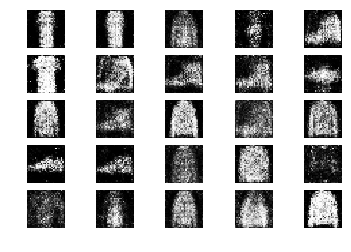

1801 [D loss: 0.679212, acc.: 53.12%] [G loss: 0.836428]
1802 [D loss: 0.667561, acc.: 64.06%] [G loss: 0.938446]
1803 [D loss: 0.604434, acc.: 70.31%] [G loss: 0.944774]
1804 [D loss: 0.624937, acc.: 64.06%] [G loss: 0.911788]
1805 [D loss: 0.573047, acc.: 76.56%] [G loss: 0.900019]
1806 [D loss: 0.615071, acc.: 62.50%] [G loss: 0.992929]
1807 [D loss: 0.607116, acc.: 60.94%] [G loss: 0.914658]
1808 [D loss: 0.589951, acc.: 70.31%] [G loss: 0.991695]
1809 [D loss: 0.617109, acc.: 68.75%] [G loss: 0.871863]
1810 [D loss: 0.679737, acc.: 64.06%] [G loss: 0.871522]
1811 [D loss: 0.588220, acc.: 67.19%] [G loss: 0.961183]
1812 [D loss: 0.622371, acc.: 62.50%] [G loss: 0.970395]
1813 [D loss: 0.588717, acc.: 71.88%] [G loss: 1.017194]
1814 [D loss: 0.646940, acc.: 59.38%] [G loss: 0.960915]
1815 [D loss: 0.613361, acc.: 64.06%] [G loss: 0.866598]
1816 [D loss: 0.567762, acc.: 70.31%] [G loss: 0.952937]
1817 [D loss: 0.699412, acc.: 56.25%] [G loss: 0.858045]
1818 [D loss: 0.626771, acc.: 6

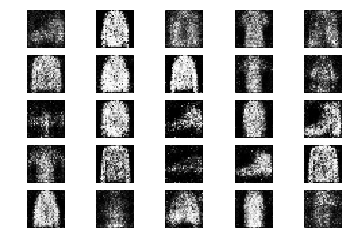

2001 [D loss: 0.621215, acc.: 65.62%] [G loss: 0.930150]
2002 [D loss: 0.614422, acc.: 62.50%] [G loss: 0.927157]
2003 [D loss: 0.656889, acc.: 59.38%] [G loss: 0.987103]
2004 [D loss: 0.652678, acc.: 59.38%] [G loss: 0.903505]
2005 [D loss: 0.616161, acc.: 70.31%] [G loss: 0.837241]
2006 [D loss: 0.549605, acc.: 75.00%] [G loss: 0.922724]
2007 [D loss: 0.625200, acc.: 60.94%] [G loss: 0.887230]
2008 [D loss: 0.540047, acc.: 68.75%] [G loss: 0.894272]
2009 [D loss: 0.603610, acc.: 59.38%] [G loss: 0.895686]
2010 [D loss: 0.595691, acc.: 70.31%] [G loss: 0.891233]
2011 [D loss: 0.611095, acc.: 64.06%] [G loss: 0.975214]
2012 [D loss: 0.639375, acc.: 59.38%] [G loss: 1.021544]
2013 [D loss: 0.536371, acc.: 76.56%] [G loss: 1.016014]
2014 [D loss: 0.763104, acc.: 45.31%] [G loss: 0.945820]
2015 [D loss: 0.647778, acc.: 59.38%] [G loss: 0.859178]
2016 [D loss: 0.669257, acc.: 57.81%] [G loss: 0.990176]
2017 [D loss: 0.619555, acc.: 68.75%] [G loss: 0.946555]
2018 [D loss: 0.638040, acc.: 5

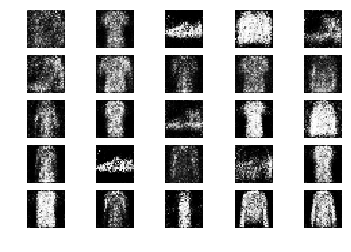

2201 [D loss: 0.591838, acc.: 65.62%] [G loss: 0.939072]
2202 [D loss: 0.638215, acc.: 65.62%] [G loss: 0.851866]
2203 [D loss: 0.579439, acc.: 75.00%] [G loss: 0.918031]
2204 [D loss: 0.602178, acc.: 64.06%] [G loss: 0.875328]
2205 [D loss: 0.584648, acc.: 71.88%] [G loss: 0.910708]
2206 [D loss: 0.631607, acc.: 65.62%] [G loss: 0.893745]
2207 [D loss: 0.573376, acc.: 65.62%] [G loss: 0.913143]
2208 [D loss: 0.645634, acc.: 64.06%] [G loss: 0.870479]
2209 [D loss: 0.672956, acc.: 59.38%] [G loss: 0.945244]
2210 [D loss: 0.594863, acc.: 68.75%] [G loss: 0.954841]
2211 [D loss: 0.647201, acc.: 64.06%] [G loss: 0.860013]
2212 [D loss: 0.654617, acc.: 70.31%] [G loss: 0.804673]
2213 [D loss: 0.672439, acc.: 57.81%] [G loss: 0.926582]
2214 [D loss: 0.601914, acc.: 70.31%] [G loss: 0.827594]
2215 [D loss: 0.599911, acc.: 67.19%] [G loss: 0.852787]
2216 [D loss: 0.668737, acc.: 67.19%] [G loss: 0.915362]
2217 [D loss: 0.604458, acc.: 64.06%] [G loss: 0.985352]
2218 [D loss: 0.621900, acc.: 7

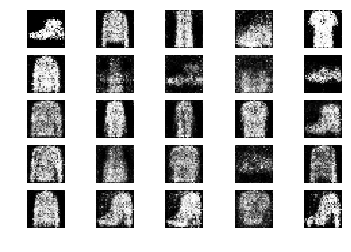

2401 [D loss: 0.629595, acc.: 62.50%] [G loss: 0.961447]
2402 [D loss: 0.736331, acc.: 53.12%] [G loss: 0.891577]
2403 [D loss: 0.609343, acc.: 62.50%] [G loss: 0.846085]
2404 [D loss: 0.636417, acc.: 67.19%] [G loss: 0.897758]
2405 [D loss: 0.586425, acc.: 73.44%] [G loss: 0.891716]
2406 [D loss: 0.552872, acc.: 68.75%] [G loss: 0.883467]
2407 [D loss: 0.624371, acc.: 65.62%] [G loss: 0.923836]
2408 [D loss: 0.612747, acc.: 67.19%] [G loss: 0.949689]
2409 [D loss: 0.650706, acc.: 60.94%] [G loss: 0.901930]
2410 [D loss: 0.637470, acc.: 65.62%] [G loss: 0.869141]
2411 [D loss: 0.619305, acc.: 64.06%] [G loss: 0.846996]
2412 [D loss: 0.642336, acc.: 56.25%] [G loss: 0.851834]
2413 [D loss: 0.635108, acc.: 60.94%] [G loss: 0.913464]
2414 [D loss: 0.577791, acc.: 76.56%] [G loss: 1.005219]
2415 [D loss: 0.601161, acc.: 67.19%] [G loss: 1.041595]
2416 [D loss: 0.565247, acc.: 75.00%] [G loss: 1.004114]
2417 [D loss: 0.657034, acc.: 64.06%] [G loss: 0.988646]
2418 [D loss: 0.688248, acc.: 5

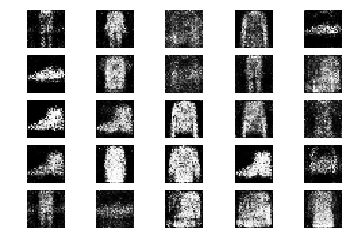

2601 [D loss: 0.569168, acc.: 68.75%] [G loss: 0.960064]
2602 [D loss: 0.621639, acc.: 67.19%] [G loss: 0.934596]
2603 [D loss: 0.658397, acc.: 64.06%] [G loss: 0.860040]
2604 [D loss: 0.609518, acc.: 67.19%] [G loss: 0.911240]
2605 [D loss: 0.680886, acc.: 56.25%] [G loss: 0.901030]
2606 [D loss: 0.596651, acc.: 65.62%] [G loss: 0.908098]
2607 [D loss: 0.647560, acc.: 65.62%] [G loss: 0.902563]
2608 [D loss: 0.681551, acc.: 51.56%] [G loss: 0.980758]
2609 [D loss: 0.612376, acc.: 67.19%] [G loss: 0.919344]
2610 [D loss: 0.683701, acc.: 48.44%] [G loss: 1.010961]
2611 [D loss: 0.592509, acc.: 65.62%] [G loss: 0.956602]
2612 [D loss: 0.672468, acc.: 60.94%] [G loss: 0.906689]
2613 [D loss: 0.582125, acc.: 68.75%] [G loss: 0.968911]
2614 [D loss: 0.618380, acc.: 57.81%] [G loss: 0.955445]
2615 [D loss: 0.708064, acc.: 54.69%] [G loss: 0.903965]
2616 [D loss: 0.634765, acc.: 64.06%] [G loss: 0.896520]
2617 [D loss: 0.643951, acc.: 56.25%] [G loss: 0.913053]
2618 [D loss: 0.534427, acc.: 7

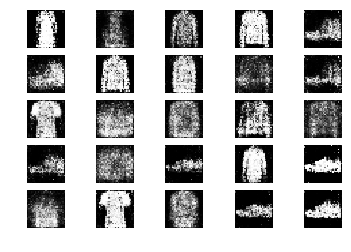

2801 [D loss: 0.614557, acc.: 71.88%] [G loss: 1.023624]
2802 [D loss: 0.601196, acc.: 62.50%] [G loss: 0.944919]
2803 [D loss: 0.598148, acc.: 68.75%] [G loss: 1.009747]
2804 [D loss: 0.615274, acc.: 62.50%] [G loss: 0.948945]
2805 [D loss: 0.617413, acc.: 68.75%] [G loss: 0.851856]
2806 [D loss: 0.613470, acc.: 64.06%] [G loss: 0.998281]
2807 [D loss: 0.593654, acc.: 71.88%] [G loss: 0.944145]
2808 [D loss: 0.681224, acc.: 62.50%] [G loss: 0.956925]
2809 [D loss: 0.609140, acc.: 64.06%] [G loss: 0.925487]
2810 [D loss: 0.632486, acc.: 67.19%] [G loss: 0.897935]
2811 [D loss: 0.675431, acc.: 57.81%] [G loss: 0.897598]
2812 [D loss: 0.626871, acc.: 59.38%] [G loss: 0.924585]
2813 [D loss: 0.706648, acc.: 53.12%] [G loss: 0.877083]
2814 [D loss: 0.656957, acc.: 65.62%] [G loss: 0.865072]
2815 [D loss: 0.710791, acc.: 53.12%] [G loss: 0.852108]
2816 [D loss: 0.565601, acc.: 73.44%] [G loss: 1.034101]
2817 [D loss: 0.601451, acc.: 67.19%] [G loss: 0.868000]
2818 [D loss: 0.579725, acc.: 6

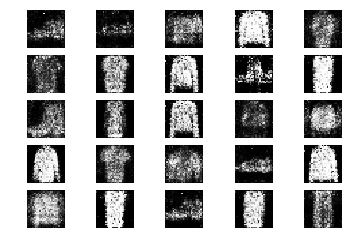

3001 [D loss: 0.622412, acc.: 60.94%] [G loss: 0.941527]
3002 [D loss: 0.714246, acc.: 57.81%] [G loss: 0.838365]
3003 [D loss: 0.643429, acc.: 60.94%] [G loss: 0.830074]
3004 [D loss: 0.623398, acc.: 67.19%] [G loss: 0.931105]
3005 [D loss: 0.617121, acc.: 67.19%] [G loss: 0.934637]
3006 [D loss: 0.672363, acc.: 62.50%] [G loss: 0.987630]
3007 [D loss: 0.657946, acc.: 53.12%] [G loss: 0.954473]
3008 [D loss: 0.634425, acc.: 62.50%] [G loss: 0.936970]
3009 [D loss: 0.708390, acc.: 53.12%] [G loss: 0.910595]
3010 [D loss: 0.621110, acc.: 64.06%] [G loss: 0.847554]
3011 [D loss: 0.576449, acc.: 71.88%] [G loss: 0.933567]
3012 [D loss: 0.645015, acc.: 54.69%] [G loss: 0.931670]
3013 [D loss: 0.566695, acc.: 73.44%] [G loss: 0.890764]
3014 [D loss: 0.558907, acc.: 73.44%] [G loss: 0.809262]
3015 [D loss: 0.591932, acc.: 68.75%] [G loss: 0.887840]
3016 [D loss: 0.567209, acc.: 73.44%] [G loss: 0.918175]
3017 [D loss: 0.583869, acc.: 70.31%] [G loss: 1.034324]
3018 [D loss: 0.769322, acc.: 4

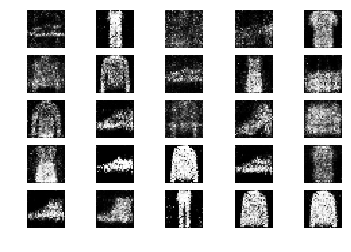

3201 [D loss: 0.652068, acc.: 62.50%] [G loss: 0.899821]
3202 [D loss: 0.651331, acc.: 62.50%] [G loss: 0.918323]
3203 [D loss: 0.625789, acc.: 59.38%] [G loss: 0.811698]
3204 [D loss: 0.631197, acc.: 67.19%] [G loss: 0.920325]
3205 [D loss: 0.605605, acc.: 65.62%] [G loss: 0.920497]
3206 [D loss: 0.626669, acc.: 73.44%] [G loss: 0.935374]
3207 [D loss: 0.640831, acc.: 67.19%] [G loss: 0.972915]
3208 [D loss: 0.593164, acc.: 64.06%] [G loss: 0.947697]
3209 [D loss: 0.632817, acc.: 64.06%] [G loss: 0.989176]
3210 [D loss: 0.674884, acc.: 64.06%] [G loss: 0.939915]
3211 [D loss: 0.669615, acc.: 62.50%] [G loss: 0.934740]
3212 [D loss: 0.563558, acc.: 71.88%] [G loss: 0.919520]
3213 [D loss: 0.639171, acc.: 65.62%] [G loss: 0.816423]
3214 [D loss: 0.622483, acc.: 59.38%] [G loss: 0.837338]
3215 [D loss: 0.720063, acc.: 53.12%] [G loss: 0.836387]
3216 [D loss: 0.671508, acc.: 56.25%] [G loss: 0.942066]
3217 [D loss: 0.610586, acc.: 68.75%] [G loss: 0.971673]
3218 [D loss: 0.561622, acc.: 7

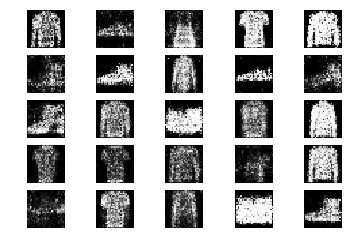

3401 [D loss: 0.555702, acc.: 76.56%] [G loss: 0.949648]
3402 [D loss: 0.618660, acc.: 60.94%] [G loss: 0.927427]
3403 [D loss: 0.607381, acc.: 64.06%] [G loss: 0.894283]
3404 [D loss: 0.619652, acc.: 70.31%] [G loss: 0.951608]
3405 [D loss: 0.664316, acc.: 60.94%] [G loss: 0.932687]
3406 [D loss: 0.619710, acc.: 67.19%] [G loss: 0.902423]
3407 [D loss: 0.546173, acc.: 75.00%] [G loss: 0.871677]
3408 [D loss: 0.596238, acc.: 70.31%] [G loss: 0.865062]
3409 [D loss: 0.627549, acc.: 64.06%] [G loss: 0.871074]
3410 [D loss: 0.638270, acc.: 67.19%] [G loss: 0.884639]
3411 [D loss: 0.654592, acc.: 62.50%] [G loss: 0.882752]
3412 [D loss: 0.580872, acc.: 70.31%] [G loss: 0.929955]
3413 [D loss: 0.675811, acc.: 54.69%] [G loss: 0.902747]
3414 [D loss: 0.606155, acc.: 67.19%] [G loss: 0.913190]
3415 [D loss: 0.581633, acc.: 68.75%] [G loss: 0.881936]
3416 [D loss: 0.672193, acc.: 53.12%] [G loss: 0.872869]
3417 [D loss: 0.666555, acc.: 54.69%] [G loss: 0.873573]
3418 [D loss: 0.723131, acc.: 5

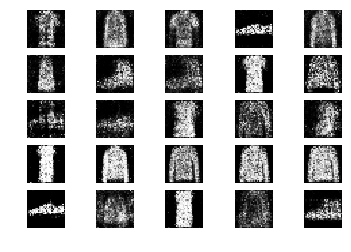

3601 [D loss: 0.666518, acc.: 64.06%] [G loss: 0.996195]
3602 [D loss: 0.612894, acc.: 65.62%] [G loss: 0.905010]
3603 [D loss: 0.667949, acc.: 62.50%] [G loss: 0.834445]
3604 [D loss: 0.660087, acc.: 59.38%] [G loss: 0.847496]
3605 [D loss: 0.671596, acc.: 56.25%] [G loss: 0.940767]
3606 [D loss: 0.581991, acc.: 75.00%] [G loss: 0.922140]
3607 [D loss: 0.605852, acc.: 65.62%] [G loss: 0.970088]
3608 [D loss: 0.637336, acc.: 62.50%] [G loss: 0.953580]
3609 [D loss: 0.628127, acc.: 57.81%] [G loss: 0.880445]
3610 [D loss: 0.650257, acc.: 57.81%] [G loss: 0.949992]
3611 [D loss: 0.719207, acc.: 51.56%] [G loss: 0.833004]
3612 [D loss: 0.643928, acc.: 65.62%] [G loss: 0.890680]
3613 [D loss: 0.602736, acc.: 68.75%] [G loss: 0.917343]
3614 [D loss: 0.627294, acc.: 65.62%] [G loss: 0.967543]
3615 [D loss: 0.627954, acc.: 64.06%] [G loss: 1.041740]
3616 [D loss: 0.615398, acc.: 59.38%] [G loss: 0.967800]
3617 [D loss: 0.674123, acc.: 59.38%] [G loss: 0.972845]
3618 [D loss: 0.675204, acc.: 6

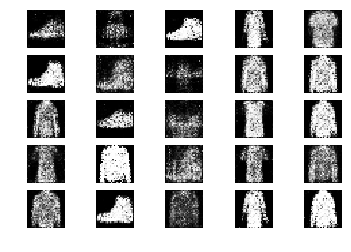

3801 [D loss: 0.669806, acc.: 59.38%] [G loss: 0.952021]
3802 [D loss: 0.586945, acc.: 64.06%] [G loss: 0.982614]
3803 [D loss: 0.683225, acc.: 64.06%] [G loss: 0.924839]
3804 [D loss: 0.666330, acc.: 57.81%] [G loss: 0.932269]
3805 [D loss: 0.624353, acc.: 65.62%] [G loss: 0.919742]
3806 [D loss: 0.759655, acc.: 53.12%] [G loss: 0.950165]
3807 [D loss: 0.628904, acc.: 64.06%] [G loss: 0.949520]
3808 [D loss: 0.637303, acc.: 65.62%] [G loss: 0.867974]
3809 [D loss: 0.679813, acc.: 62.50%] [G loss: 0.865210]
3810 [D loss: 0.579354, acc.: 75.00%] [G loss: 0.964076]
3811 [D loss: 0.678740, acc.: 56.25%] [G loss: 0.938065]
3812 [D loss: 0.644344, acc.: 64.06%] [G loss: 0.886713]
3813 [D loss: 0.651944, acc.: 59.38%] [G loss: 0.871904]
3814 [D loss: 0.687475, acc.: 54.69%] [G loss: 0.927511]
3815 [D loss: 0.650097, acc.: 56.25%] [G loss: 0.898995]
3816 [D loss: 0.595594, acc.: 71.88%] [G loss: 0.856001]
3817 [D loss: 0.601988, acc.: 73.44%] [G loss: 0.954874]
3818 [D loss: 0.645730, acc.: 5

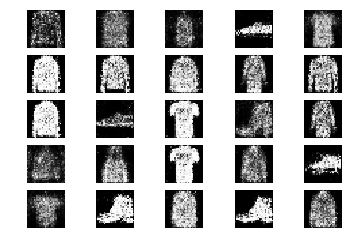

4001 [D loss: 0.659002, acc.: 59.38%] [G loss: 0.911264]
4002 [D loss: 0.609692, acc.: 60.94%] [G loss: 0.950430]
4003 [D loss: 0.689424, acc.: 51.56%] [G loss: 0.920746]
4004 [D loss: 0.614411, acc.: 65.62%] [G loss: 0.842825]
4005 [D loss: 0.629903, acc.: 64.06%] [G loss: 0.872079]
4006 [D loss: 0.613659, acc.: 67.19%] [G loss: 0.872814]
4007 [D loss: 0.664692, acc.: 57.81%] [G loss: 0.907947]
4008 [D loss: 0.583396, acc.: 65.62%] [G loss: 0.777798]
4009 [D loss: 0.585042, acc.: 73.44%] [G loss: 0.852676]
4010 [D loss: 0.691967, acc.: 60.94%] [G loss: 0.892374]
4011 [D loss: 0.747214, acc.: 59.38%] [G loss: 0.804484]
4012 [D loss: 0.673579, acc.: 64.06%] [G loss: 0.878121]
4013 [D loss: 0.672776, acc.: 59.38%] [G loss: 0.940006]
4014 [D loss: 0.604242, acc.: 70.31%] [G loss: 0.941647]
4015 [D loss: 0.616633, acc.: 65.62%] [G loss: 0.864979]
4016 [D loss: 0.651134, acc.: 65.62%] [G loss: 0.839658]
4017 [D loss: 0.600773, acc.: 65.62%] [G loss: 0.974713]
4018 [D loss: 0.631261, acc.: 6

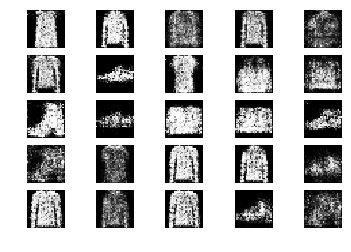

4201 [D loss: 0.619595, acc.: 67.19%] [G loss: 0.972187]
4202 [D loss: 0.719098, acc.: 56.25%] [G loss: 0.861283]
4203 [D loss: 0.621363, acc.: 56.25%] [G loss: 0.998828]
4204 [D loss: 0.623027, acc.: 57.81%] [G loss: 1.001809]
4205 [D loss: 0.701106, acc.: 54.69%] [G loss: 0.865401]
4206 [D loss: 0.621064, acc.: 60.94%] [G loss: 0.927844]
4207 [D loss: 0.663812, acc.: 60.94%] [G loss: 1.016500]
4208 [D loss: 0.635284, acc.: 64.06%] [G loss: 1.017182]
4209 [D loss: 0.656221, acc.: 64.06%] [G loss: 0.889295]
4210 [D loss: 0.543156, acc.: 79.69%] [G loss: 0.946710]
4211 [D loss: 0.621236, acc.: 67.19%] [G loss: 0.954993]
4212 [D loss: 0.608691, acc.: 68.75%] [G loss: 0.835037]
4213 [D loss: 0.640688, acc.: 67.19%] [G loss: 0.858615]
4214 [D loss: 0.743139, acc.: 50.00%] [G loss: 0.962164]
4215 [D loss: 0.638536, acc.: 64.06%] [G loss: 0.871385]
4216 [D loss: 0.586571, acc.: 76.56%] [G loss: 0.964288]
4217 [D loss: 0.658451, acc.: 64.06%] [G loss: 0.882663]
4218 [D loss: 0.713249, acc.: 5

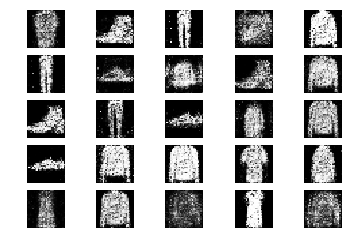

4401 [D loss: 0.690161, acc.: 57.81%] [G loss: 0.916056]
4402 [D loss: 0.649324, acc.: 56.25%] [G loss: 0.855556]
4403 [D loss: 0.639779, acc.: 64.06%] [G loss: 0.944026]
4404 [D loss: 0.657414, acc.: 65.62%] [G loss: 0.892591]
4405 [D loss: 0.617970, acc.: 60.94%] [G loss: 0.906702]
4406 [D loss: 0.669308, acc.: 71.88%] [G loss: 0.820105]
4407 [D loss: 0.607736, acc.: 68.75%] [G loss: 0.950755]
4408 [D loss: 0.719300, acc.: 53.12%] [G loss: 0.851051]
4409 [D loss: 0.668572, acc.: 53.12%] [G loss: 0.902477]
4410 [D loss: 0.632748, acc.: 60.94%] [G loss: 0.893303]
4411 [D loss: 0.676358, acc.: 50.00%] [G loss: 1.011312]
4412 [D loss: 0.633385, acc.: 64.06%] [G loss: 0.962006]
4413 [D loss: 0.589339, acc.: 68.75%] [G loss: 1.025625]
4414 [D loss: 0.614848, acc.: 60.94%] [G loss: 0.954819]
4415 [D loss: 0.663255, acc.: 57.81%] [G loss: 0.903337]
4416 [D loss: 0.667221, acc.: 59.38%] [G loss: 0.933839]
4417 [D loss: 0.613337, acc.: 68.75%] [G loss: 0.949612]
4418 [D loss: 0.594258, acc.: 7

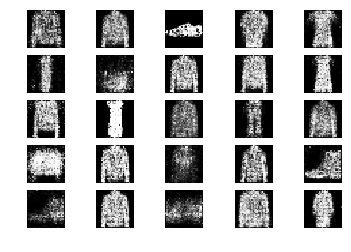

4601 [D loss: 0.671524, acc.: 54.69%] [G loss: 0.933786]
4602 [D loss: 0.597874, acc.: 71.88%] [G loss: 0.939933]
4603 [D loss: 0.617432, acc.: 70.31%] [G loss: 1.006060]
4604 [D loss: 0.583626, acc.: 70.31%] [G loss: 1.015981]
4605 [D loss: 0.689838, acc.: 56.25%] [G loss: 0.962546]
4606 [D loss: 0.620319, acc.: 67.19%] [G loss: 0.944709]
4607 [D loss: 0.614882, acc.: 73.44%] [G loss: 0.927918]
4608 [D loss: 0.664942, acc.: 57.81%] [G loss: 0.841237]
4609 [D loss: 0.711725, acc.: 50.00%] [G loss: 0.922795]
4610 [D loss: 0.628027, acc.: 71.88%] [G loss: 0.947385]
4611 [D loss: 0.657184, acc.: 59.38%] [G loss: 0.912139]
4612 [D loss: 0.595229, acc.: 70.31%] [G loss: 0.947202]
4613 [D loss: 0.643481, acc.: 59.38%] [G loss: 0.857061]
4614 [D loss: 0.647079, acc.: 59.38%] [G loss: 0.885993]
4615 [D loss: 0.631460, acc.: 65.62%] [G loss: 0.875324]
4616 [D loss: 0.663542, acc.: 65.62%] [G loss: 0.876619]
4617 [D loss: 0.580172, acc.: 73.44%] [G loss: 0.934305]
4618 [D loss: 0.706718, acc.: 5

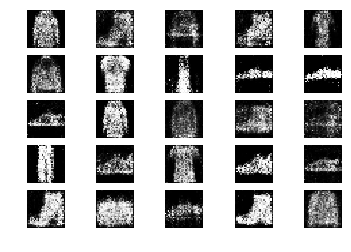

4801 [D loss: 0.676424, acc.: 57.81%] [G loss: 0.935255]
4802 [D loss: 0.656142, acc.: 62.50%] [G loss: 0.959051]
4803 [D loss: 0.635738, acc.: 70.31%] [G loss: 0.942956]
4804 [D loss: 0.679950, acc.: 57.81%] [G loss: 0.875619]
4805 [D loss: 0.601585, acc.: 73.44%] [G loss: 0.866921]
4806 [D loss: 0.671102, acc.: 54.69%] [G loss: 0.898431]
4807 [D loss: 0.684135, acc.: 53.12%] [G loss: 0.858610]
4808 [D loss: 0.606695, acc.: 70.31%] [G loss: 0.891067]
4809 [D loss: 0.608683, acc.: 67.19%] [G loss: 0.870271]
4810 [D loss: 0.639930, acc.: 64.06%] [G loss: 0.913518]
4811 [D loss: 0.592411, acc.: 71.88%] [G loss: 0.833346]
4812 [D loss: 0.624277, acc.: 67.19%] [G loss: 0.952711]
4813 [D loss: 0.655108, acc.: 60.94%] [G loss: 0.856624]
4814 [D loss: 0.553510, acc.: 71.88%] [G loss: 0.860191]
4815 [D loss: 0.636629, acc.: 60.94%] [G loss: 0.916706]
4816 [D loss: 0.650312, acc.: 62.50%] [G loss: 0.827129]
4817 [D loss: 0.585908, acc.: 67.19%] [G loss: 0.896678]
4818 [D loss: 0.642732, acc.: 6

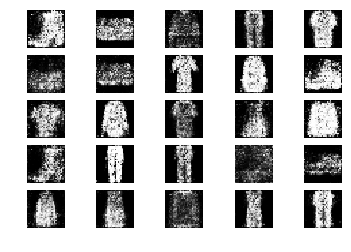

5001 [D loss: 0.729634, acc.: 56.25%] [G loss: 1.023263]
5002 [D loss: 0.647477, acc.: 57.81%] [G loss: 0.983666]
5003 [D loss: 0.634685, acc.: 64.06%] [G loss: 0.909677]
5004 [D loss: 0.596211, acc.: 76.56%] [G loss: 0.899576]
5005 [D loss: 0.654325, acc.: 54.69%] [G loss: 0.963695]
5006 [D loss: 0.650654, acc.: 64.06%] [G loss: 0.889509]
5007 [D loss: 0.646349, acc.: 59.38%] [G loss: 0.914054]
5008 [D loss: 0.638375, acc.: 64.06%] [G loss: 1.006182]
5009 [D loss: 0.649526, acc.: 67.19%] [G loss: 0.881714]
5010 [D loss: 0.699853, acc.: 54.69%] [G loss: 0.875006]
5011 [D loss: 0.717998, acc.: 50.00%] [G loss: 0.858713]
5012 [D loss: 0.587308, acc.: 71.88%] [G loss: 0.798831]
5013 [D loss: 0.626515, acc.: 68.75%] [G loss: 0.819187]
5014 [D loss: 0.669339, acc.: 60.94%] [G loss: 0.895658]
5015 [D loss: 0.670965, acc.: 57.81%] [G loss: 0.869993]
5016 [D loss: 0.592013, acc.: 73.44%] [G loss: 0.871846]
5017 [D loss: 0.663642, acc.: 53.12%] [G loss: 0.887542]
5018 [D loss: 0.596056, acc.: 6

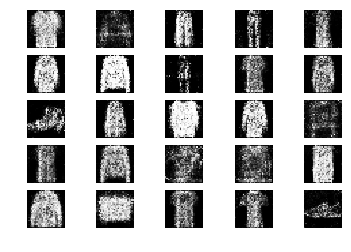

5201 [D loss: 0.611506, acc.: 67.19%] [G loss: 0.896364]
5202 [D loss: 0.664820, acc.: 53.12%] [G loss: 0.914232]
5203 [D loss: 0.646017, acc.: 62.50%] [G loss: 0.887987]
5204 [D loss: 0.582847, acc.: 71.88%] [G loss: 0.977172]
5205 [D loss: 0.644314, acc.: 59.38%] [G loss: 0.846598]
5206 [D loss: 0.567383, acc.: 70.31%] [G loss: 0.817295]
5207 [D loss: 0.687290, acc.: 48.44%] [G loss: 0.887625]
5208 [D loss: 0.631949, acc.: 64.06%] [G loss: 0.870125]
5209 [D loss: 0.633109, acc.: 68.75%] [G loss: 0.842755]
5210 [D loss: 0.612130, acc.: 65.62%] [G loss: 0.797182]
5211 [D loss: 0.639136, acc.: 68.75%] [G loss: 0.901862]
5212 [D loss: 0.650861, acc.: 64.06%] [G loss: 0.916956]
5213 [D loss: 0.640707, acc.: 59.38%] [G loss: 0.857382]
5214 [D loss: 0.599897, acc.: 75.00%] [G loss: 0.939507]
5215 [D loss: 0.636285, acc.: 73.44%] [G loss: 0.879008]
5216 [D loss: 0.625164, acc.: 67.19%] [G loss: 0.891047]
5217 [D loss: 0.679948, acc.: 64.06%] [G loss: 0.977890]
5218 [D loss: 0.679360, acc.: 5

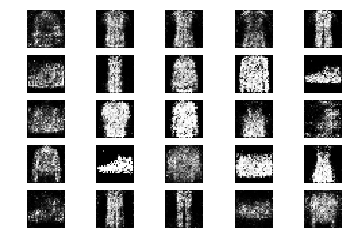

5401 [D loss: 0.706384, acc.: 57.81%] [G loss: 0.786427]
5402 [D loss: 0.563217, acc.: 78.12%] [G loss: 0.846818]
5403 [D loss: 0.632174, acc.: 67.19%] [G loss: 0.927449]
5404 [D loss: 0.688253, acc.: 57.81%] [G loss: 0.864612]
5405 [D loss: 0.620980, acc.: 68.75%] [G loss: 0.887611]
5406 [D loss: 0.580018, acc.: 75.00%] [G loss: 0.919921]
5407 [D loss: 0.696555, acc.: 62.50%] [G loss: 0.924650]
5408 [D loss: 0.642826, acc.: 62.50%] [G loss: 0.965739]
5409 [D loss: 0.601718, acc.: 75.00%] [G loss: 0.868490]
5410 [D loss: 0.643313, acc.: 70.31%] [G loss: 0.867281]
5411 [D loss: 0.625609, acc.: 73.44%] [G loss: 0.901292]
5412 [D loss: 0.590905, acc.: 71.88%] [G loss: 0.885048]
5413 [D loss: 0.650716, acc.: 60.94%] [G loss: 0.907067]
5414 [D loss: 0.636236, acc.: 54.69%] [G loss: 0.838323]
5415 [D loss: 0.668655, acc.: 54.69%] [G loss: 0.858344]
5416 [D loss: 0.652640, acc.: 57.81%] [G loss: 0.733805]
5417 [D loss: 0.666551, acc.: 62.50%] [G loss: 0.867339]
5418 [D loss: 0.624150, acc.: 7

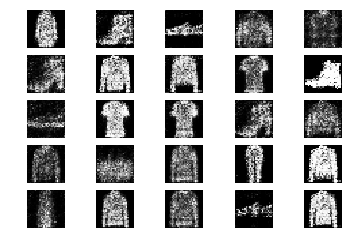

5601 [D loss: 0.631873, acc.: 60.94%] [G loss: 0.825519]
5602 [D loss: 0.653478, acc.: 53.12%] [G loss: 0.858613]
5603 [D loss: 0.609386, acc.: 65.62%] [G loss: 0.869054]
5604 [D loss: 0.633085, acc.: 62.50%] [G loss: 0.902537]
5605 [D loss: 0.687513, acc.: 56.25%] [G loss: 0.974375]
5606 [D loss: 0.654534, acc.: 59.38%] [G loss: 0.881341]
5607 [D loss: 0.697905, acc.: 54.69%] [G loss: 0.936736]
5608 [D loss: 0.620681, acc.: 70.31%] [G loss: 0.904987]
5609 [D loss: 0.678892, acc.: 46.88%] [G loss: 0.961046]
5610 [D loss: 0.697487, acc.: 57.81%] [G loss: 0.896492]
5611 [D loss: 0.654643, acc.: 67.19%] [G loss: 0.904617]
5612 [D loss: 0.715298, acc.: 50.00%] [G loss: 0.861857]
5613 [D loss: 0.638018, acc.: 60.94%] [G loss: 0.956302]
5614 [D loss: 0.631740, acc.: 67.19%] [G loss: 0.893406]
5615 [D loss: 0.636686, acc.: 62.50%] [G loss: 0.877396]
5616 [D loss: 0.675329, acc.: 60.94%] [G loss: 0.915333]
5617 [D loss: 0.658092, acc.: 54.69%] [G loss: 0.887391]
5618 [D loss: 0.573624, acc.: 7

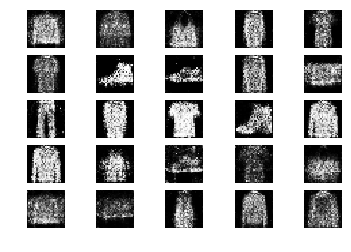

5801 [D loss: 0.671023, acc.: 57.81%] [G loss: 0.872544]
5802 [D loss: 0.689504, acc.: 50.00%] [G loss: 0.921421]
5803 [D loss: 0.673389, acc.: 53.12%] [G loss: 0.885729]
5804 [D loss: 0.623320, acc.: 67.19%] [G loss: 0.878411]
5805 [D loss: 0.651975, acc.: 60.94%] [G loss: 0.879587]
5806 [D loss: 0.664706, acc.: 57.81%] [G loss: 0.823368]
5807 [D loss: 0.670566, acc.: 57.81%] [G loss: 0.884447]
5808 [D loss: 0.704508, acc.: 53.12%] [G loss: 0.893260]
5809 [D loss: 0.676224, acc.: 64.06%] [G loss: 0.925203]
5810 [D loss: 0.646532, acc.: 62.50%] [G loss: 0.868023]
5811 [D loss: 0.655036, acc.: 68.75%] [G loss: 0.843255]
5812 [D loss: 0.677115, acc.: 60.94%] [G loss: 0.884693]
5813 [D loss: 0.647027, acc.: 60.94%] [G loss: 0.826609]
5814 [D loss: 0.579916, acc.: 78.12%] [G loss: 0.847161]
5815 [D loss: 0.643003, acc.: 62.50%] [G loss: 0.854959]
5816 [D loss: 0.663363, acc.: 57.81%] [G loss: 0.874942]
5817 [D loss: 0.703978, acc.: 53.12%] [G loss: 0.828809]
5818 [D loss: 0.680624, acc.: 6

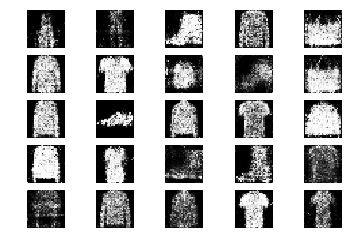

6001 [D loss: 0.620564, acc.: 65.62%] [G loss: 0.880320]
6002 [D loss: 0.662481, acc.: 56.25%] [G loss: 0.902915]
6003 [D loss: 0.594062, acc.: 75.00%] [G loss: 0.852926]
6004 [D loss: 0.651675, acc.: 64.06%] [G loss: 0.847820]
6005 [D loss: 0.621710, acc.: 67.19%] [G loss: 0.949911]
6006 [D loss: 0.662527, acc.: 59.38%] [G loss: 0.938077]
6007 [D loss: 0.669115, acc.: 54.69%] [G loss: 1.003856]
6008 [D loss: 0.652960, acc.: 67.19%] [G loss: 0.872781]
6009 [D loss: 0.696596, acc.: 60.94%] [G loss: 0.912174]
6010 [D loss: 0.658933, acc.: 62.50%] [G loss: 0.839705]
6011 [D loss: 0.585777, acc.: 70.31%] [G loss: 0.961807]
6012 [D loss: 0.599595, acc.: 68.75%] [G loss: 0.966219]
6013 [D loss: 0.590361, acc.: 65.62%] [G loss: 0.960931]
6014 [D loss: 0.609215, acc.: 67.19%] [G loss: 0.938622]
6015 [D loss: 0.607346, acc.: 64.06%] [G loss: 0.902402]
6016 [D loss: 0.645906, acc.: 57.81%] [G loss: 0.939199]
6017 [D loss: 0.644342, acc.: 67.19%] [G loss: 0.902227]
6018 [D loss: 0.631600, acc.: 5

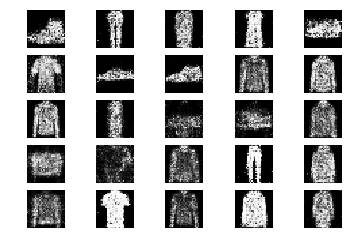

6201 [D loss: 0.646581, acc.: 59.38%] [G loss: 0.850768]
6202 [D loss: 0.709528, acc.: 46.88%] [G loss: 0.831099]
6203 [D loss: 0.650034, acc.: 59.38%] [G loss: 0.877451]
6204 [D loss: 0.587979, acc.: 67.19%] [G loss: 0.834377]
6205 [D loss: 0.637283, acc.: 65.62%] [G loss: 0.941763]
6206 [D loss: 0.662874, acc.: 56.25%] [G loss: 0.913963]
6207 [D loss: 0.657560, acc.: 57.81%] [G loss: 0.960694]
6208 [D loss: 0.646457, acc.: 62.50%] [G loss: 0.848299]
6209 [D loss: 0.620807, acc.: 65.62%] [G loss: 0.895139]
6210 [D loss: 0.665085, acc.: 68.75%] [G loss: 0.878936]
6211 [D loss: 0.666702, acc.: 67.19%] [G loss: 0.885579]
6212 [D loss: 0.675555, acc.: 57.81%] [G loss: 0.859325]
6213 [D loss: 0.659578, acc.: 60.94%] [G loss: 0.876463]
6214 [D loss: 0.680303, acc.: 59.38%] [G loss: 0.971398]
6215 [D loss: 0.707434, acc.: 45.31%] [G loss: 0.887330]
6216 [D loss: 0.658826, acc.: 60.94%] [G loss: 0.925433]
6217 [D loss: 0.651697, acc.: 59.38%] [G loss: 0.883580]
6218 [D loss: 0.736339, acc.: 5

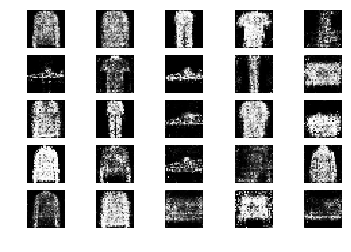

6401 [D loss: 0.647058, acc.: 59.38%] [G loss: 0.858648]
6402 [D loss: 0.621080, acc.: 62.50%] [G loss: 0.829665]
6403 [D loss: 0.647214, acc.: 56.25%] [G loss: 0.981027]
6404 [D loss: 0.661119, acc.: 59.38%] [G loss: 0.927966]
6405 [D loss: 0.665253, acc.: 57.81%] [G loss: 0.867970]
6406 [D loss: 0.667210, acc.: 62.50%] [G loss: 1.008885]
6407 [D loss: 0.661653, acc.: 59.38%] [G loss: 0.898494]
6408 [D loss: 0.643169, acc.: 59.38%] [G loss: 0.910236]
6409 [D loss: 0.717042, acc.: 46.88%] [G loss: 0.863563]
6410 [D loss: 0.675887, acc.: 59.38%] [G loss: 0.855268]
6411 [D loss: 0.631773, acc.: 57.81%] [G loss: 0.871280]
6412 [D loss: 0.728720, acc.: 56.25%] [G loss: 0.889898]
6413 [D loss: 0.628503, acc.: 67.19%] [G loss: 0.925861]
6414 [D loss: 0.631735, acc.: 65.62%] [G loss: 0.869317]
6415 [D loss: 0.676120, acc.: 64.06%] [G loss: 0.937340]
6416 [D loss: 0.640964, acc.: 60.94%] [G loss: 0.838038]
6417 [D loss: 0.673298, acc.: 64.06%] [G loss: 0.887252]
6418 [D loss: 0.614860, acc.: 6

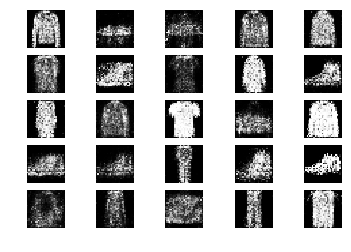

6601 [D loss: 0.597076, acc.: 70.31%] [G loss: 0.892211]
6602 [D loss: 0.677574, acc.: 65.62%] [G loss: 0.945271]
6603 [D loss: 0.661524, acc.: 56.25%] [G loss: 0.911161]
6604 [D loss: 0.677308, acc.: 54.69%] [G loss: 0.952749]
6605 [D loss: 0.726094, acc.: 51.56%] [G loss: 0.801656]
6606 [D loss: 0.631549, acc.: 64.06%] [G loss: 0.924609]
6607 [D loss: 0.655331, acc.: 65.62%] [G loss: 0.806421]
6608 [D loss: 0.645364, acc.: 60.94%] [G loss: 0.793992]
6609 [D loss: 0.680211, acc.: 57.81%] [G loss: 0.941567]
6610 [D loss: 0.742206, acc.: 53.12%] [G loss: 0.803676]
6611 [D loss: 0.658723, acc.: 57.81%] [G loss: 0.877982]
6612 [D loss: 0.624467, acc.: 67.19%] [G loss: 0.863024]
6613 [D loss: 0.648587, acc.: 67.19%] [G loss: 0.884773]
6614 [D loss: 0.668684, acc.: 64.06%] [G loss: 0.913198]
6615 [D loss: 0.663482, acc.: 54.69%] [G loss: 0.950656]
6616 [D loss: 0.617730, acc.: 67.19%] [G loss: 0.921769]
6617 [D loss: 0.652812, acc.: 64.06%] [G loss: 0.876862]
6618 [D loss: 0.690846, acc.: 5

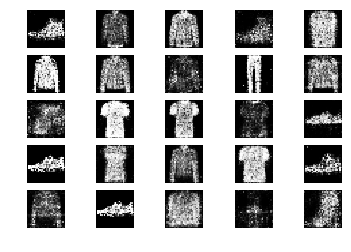

6801 [D loss: 0.778638, acc.: 45.31%] [G loss: 1.005457]
6802 [D loss: 0.661326, acc.: 67.19%] [G loss: 0.969114]
6803 [D loss: 0.644034, acc.: 67.19%] [G loss: 0.904430]
6804 [D loss: 0.660512, acc.: 65.62%] [G loss: 0.899511]
6805 [D loss: 0.636981, acc.: 67.19%] [G loss: 0.851727]
6806 [D loss: 0.681519, acc.: 56.25%] [G loss: 0.901804]
6807 [D loss: 0.658378, acc.: 64.06%] [G loss: 0.866739]
6808 [D loss: 0.616943, acc.: 70.31%] [G loss: 0.918380]
6809 [D loss: 0.621605, acc.: 68.75%] [G loss: 0.841281]
6810 [D loss: 0.659561, acc.: 60.94%] [G loss: 0.845602]
6811 [D loss: 0.635909, acc.: 64.06%] [G loss: 0.920201]
6812 [D loss: 0.690761, acc.: 59.38%] [G loss: 0.885830]
6813 [D loss: 0.650356, acc.: 67.19%] [G loss: 0.764867]
6814 [D loss: 0.653394, acc.: 62.50%] [G loss: 0.790344]
6815 [D loss: 0.687887, acc.: 56.25%] [G loss: 0.935758]
6816 [D loss: 0.647758, acc.: 62.50%] [G loss: 0.922948]
6817 [D loss: 0.720344, acc.: 53.12%] [G loss: 0.923571]
6818 [D loss: 0.667785, acc.: 6

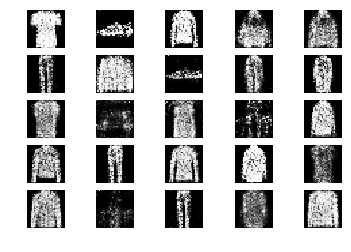

7001 [D loss: 0.698040, acc.: 53.12%] [G loss: 0.918600]
7002 [D loss: 0.637716, acc.: 62.50%] [G loss: 0.866395]
7003 [D loss: 0.604119, acc.: 60.94%] [G loss: 0.894671]
7004 [D loss: 0.598064, acc.: 73.44%] [G loss: 0.925169]
7005 [D loss: 0.662625, acc.: 64.06%] [G loss: 0.921053]
7006 [D loss: 0.647690, acc.: 54.69%] [G loss: 0.904534]
7007 [D loss: 0.652633, acc.: 53.12%] [G loss: 0.919877]
7008 [D loss: 0.593870, acc.: 68.75%] [G loss: 0.869458]
7009 [D loss: 0.693218, acc.: 53.12%] [G loss: 0.916658]
7010 [D loss: 0.702263, acc.: 56.25%] [G loss: 0.910136]
7011 [D loss: 0.715748, acc.: 57.81%] [G loss: 0.863424]
7012 [D loss: 0.615749, acc.: 60.94%] [G loss: 0.925909]
7013 [D loss: 0.660831, acc.: 59.38%] [G loss: 0.978791]
7014 [D loss: 0.592779, acc.: 70.31%] [G loss: 0.925804]
7015 [D loss: 0.650293, acc.: 60.94%] [G loss: 0.882708]
7016 [D loss: 0.662973, acc.: 57.81%] [G loss: 0.841940]
7017 [D loss: 0.626626, acc.: 60.94%] [G loss: 0.850057]
7018 [D loss: 0.623793, acc.: 6

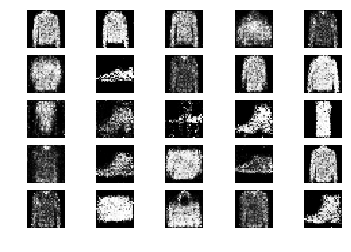

7201 [D loss: 0.716826, acc.: 48.44%] [G loss: 0.868024]
7202 [D loss: 0.675345, acc.: 56.25%] [G loss: 0.855792]
7203 [D loss: 0.675951, acc.: 56.25%] [G loss: 0.871393]
7204 [D loss: 0.731933, acc.: 59.38%] [G loss: 0.896582]
7205 [D loss: 0.596416, acc.: 70.31%] [G loss: 0.873820]
7206 [D loss: 0.621826, acc.: 65.62%] [G loss: 0.845590]
7207 [D loss: 0.656200, acc.: 62.50%] [G loss: 0.780051]
7208 [D loss: 0.671693, acc.: 54.69%] [G loss: 0.832649]
7209 [D loss: 0.662832, acc.: 62.50%] [G loss: 0.863570]
7210 [D loss: 0.721891, acc.: 48.44%] [G loss: 0.826194]
7211 [D loss: 0.657385, acc.: 60.94%] [G loss: 0.875677]
7212 [D loss: 0.634141, acc.: 64.06%] [G loss: 0.856857]
7213 [D loss: 0.626614, acc.: 67.19%] [G loss: 0.800025]
7214 [D loss: 0.653606, acc.: 54.69%] [G loss: 0.876330]
7215 [D loss: 0.726029, acc.: 51.56%] [G loss: 0.878148]
7216 [D loss: 0.667180, acc.: 57.81%] [G loss: 0.900538]
7217 [D loss: 0.680904, acc.: 53.12%] [G loss: 0.916193]
7218 [D loss: 0.616116, acc.: 6

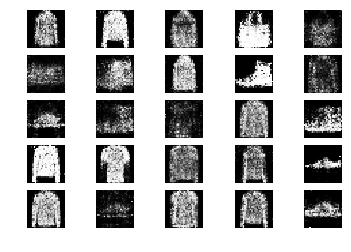

7401 [D loss: 0.610143, acc.: 60.94%] [G loss: 0.836956]
7402 [D loss: 0.674387, acc.: 60.94%] [G loss: 0.972721]
7403 [D loss: 0.623607, acc.: 70.31%] [G loss: 0.858230]
7404 [D loss: 0.602468, acc.: 70.31%] [G loss: 0.845692]
7405 [D loss: 0.667934, acc.: 59.38%] [G loss: 0.917730]
7406 [D loss: 0.637541, acc.: 53.12%] [G loss: 0.822967]
7407 [D loss: 0.644689, acc.: 62.50%] [G loss: 0.855539]
7408 [D loss: 0.698457, acc.: 59.38%] [G loss: 0.862830]
7409 [D loss: 0.682646, acc.: 50.00%] [G loss: 0.848256]
7410 [D loss: 0.663738, acc.: 56.25%] [G loss: 0.917207]
7411 [D loss: 0.618054, acc.: 71.88%] [G loss: 0.836537]
7412 [D loss: 0.718862, acc.: 59.38%] [G loss: 0.924836]
7413 [D loss: 0.683211, acc.: 56.25%] [G loss: 0.898428]
7414 [D loss: 0.657997, acc.: 64.06%] [G loss: 0.885426]
7415 [D loss: 0.685460, acc.: 56.25%] [G loss: 0.939812]
7416 [D loss: 0.696154, acc.: 57.81%] [G loss: 0.854242]
7417 [D loss: 0.619249, acc.: 65.62%] [G loss: 0.941646]
7418 [D loss: 0.625558, acc.: 6

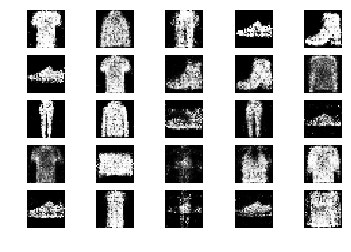

7601 [D loss: 0.654625, acc.: 60.94%] [G loss: 0.914332]
7602 [D loss: 0.688258, acc.: 56.25%] [G loss: 0.915942]
7603 [D loss: 0.662406, acc.: 54.69%] [G loss: 0.927948]
7604 [D loss: 0.653930, acc.: 62.50%] [G loss: 0.888886]
7605 [D loss: 0.629170, acc.: 67.19%] [G loss: 0.863881]
7606 [D loss: 0.625637, acc.: 71.88%] [G loss: 0.940513]
7607 [D loss: 0.695219, acc.: 57.81%] [G loss: 0.926110]
7608 [D loss: 0.623034, acc.: 62.50%] [G loss: 0.909688]
7609 [D loss: 0.676364, acc.: 59.38%] [G loss: 0.914228]
7610 [D loss: 0.633792, acc.: 70.31%] [G loss: 0.866998]
7611 [D loss: 0.641171, acc.: 64.06%] [G loss: 0.892157]
7612 [D loss: 0.668133, acc.: 56.25%] [G loss: 0.926145]
7613 [D loss: 0.627847, acc.: 62.50%] [G loss: 0.865055]
7614 [D loss: 0.628031, acc.: 68.75%] [G loss: 0.900328]
7615 [D loss: 0.695800, acc.: 51.56%] [G loss: 0.849097]
7616 [D loss: 0.629317, acc.: 64.06%] [G loss: 0.907427]
7617 [D loss: 0.610321, acc.: 71.88%] [G loss: 0.908972]
7618 [D loss: 0.626041, acc.: 6

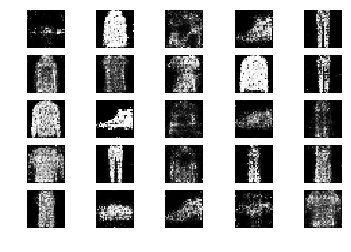

7801 [D loss: 0.658415, acc.: 62.50%] [G loss: 0.881030]
7802 [D loss: 0.618734, acc.: 65.62%] [G loss: 0.926546]
7803 [D loss: 0.654971, acc.: 57.81%] [G loss: 0.944204]
7804 [D loss: 0.682602, acc.: 62.50%] [G loss: 0.954353]
7805 [D loss: 0.606116, acc.: 67.19%] [G loss: 1.027235]
7806 [D loss: 0.596180, acc.: 67.19%] [G loss: 0.923673]
7807 [D loss: 0.596212, acc.: 71.88%] [G loss: 0.927642]
7808 [D loss: 0.678003, acc.: 59.38%] [G loss: 0.954995]
7809 [D loss: 0.669944, acc.: 56.25%] [G loss: 0.911978]
7810 [D loss: 0.639510, acc.: 65.62%] [G loss: 0.924297]
7811 [D loss: 0.638039, acc.: 60.94%] [G loss: 0.895897]
7812 [D loss: 0.624093, acc.: 68.75%] [G loss: 0.945580]
7813 [D loss: 0.618664, acc.: 64.06%] [G loss: 0.863820]
7814 [D loss: 0.614720, acc.: 68.75%] [G loss: 0.961313]
7815 [D loss: 0.799209, acc.: 50.00%] [G loss: 0.976351]
7816 [D loss: 0.617685, acc.: 73.44%] [G loss: 0.985871]
7817 [D loss: 0.697017, acc.: 51.56%] [G loss: 0.831844]
7818 [D loss: 0.647517, acc.: 6

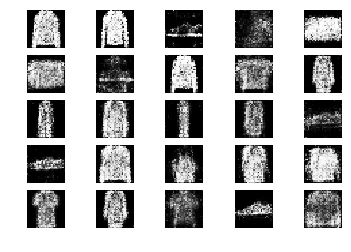

8001 [D loss: 0.679201, acc.: 60.94%] [G loss: 0.845237]
8002 [D loss: 0.611790, acc.: 62.50%] [G loss: 0.997916]
8003 [D loss: 0.683905, acc.: 59.38%] [G loss: 1.067489]
8004 [D loss: 0.623867, acc.: 65.62%] [G loss: 0.975756]
8005 [D loss: 0.617887, acc.: 65.62%] [G loss: 0.911218]
8006 [D loss: 0.711165, acc.: 48.44%] [G loss: 0.825901]
8007 [D loss: 0.618511, acc.: 71.88%] [G loss: 0.911956]
8008 [D loss: 0.665073, acc.: 62.50%] [G loss: 0.809981]
8009 [D loss: 0.643412, acc.: 62.50%] [G loss: 0.909375]
8010 [D loss: 0.677797, acc.: 59.38%] [G loss: 0.900550]
8011 [D loss: 0.629785, acc.: 56.25%] [G loss: 0.806064]
8012 [D loss: 0.630935, acc.: 67.19%] [G loss: 0.930677]
8013 [D loss: 0.665281, acc.: 56.25%] [G loss: 0.891801]
8014 [D loss: 0.664432, acc.: 60.94%] [G loss: 0.843668]
8015 [D loss: 0.627967, acc.: 71.88%] [G loss: 0.899992]
8016 [D loss: 0.630838, acc.: 73.44%] [G loss: 0.825217]
8017 [D loss: 0.623006, acc.: 65.62%] [G loss: 0.852239]
8018 [D loss: 0.670661, acc.: 5

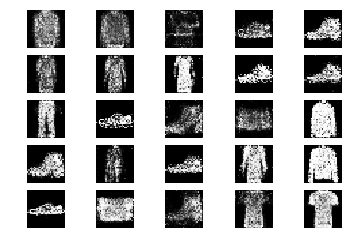

8201 [D loss: 0.657814, acc.: 60.94%] [G loss: 0.883014]
8202 [D loss: 0.611896, acc.: 64.06%] [G loss: 0.878252]
8203 [D loss: 0.616545, acc.: 65.62%] [G loss: 0.868410]
8204 [D loss: 0.654260, acc.: 53.12%] [G loss: 0.822663]
8205 [D loss: 0.710808, acc.: 51.56%] [G loss: 0.915994]
8206 [D loss: 0.662873, acc.: 60.94%] [G loss: 0.872844]
8207 [D loss: 0.566544, acc.: 75.00%] [G loss: 0.918924]
8208 [D loss: 0.688844, acc.: 57.81%] [G loss: 0.902818]
8209 [D loss: 0.564200, acc.: 71.88%] [G loss: 0.891844]
8210 [D loss: 0.628095, acc.: 68.75%] [G loss: 0.868010]
8211 [D loss: 0.761440, acc.: 45.31%] [G loss: 0.945672]
8212 [D loss: 0.620844, acc.: 67.19%] [G loss: 0.892634]
8213 [D loss: 0.650265, acc.: 60.94%] [G loss: 0.809719]
8214 [D loss: 0.616373, acc.: 65.62%] [G loss: 0.842059]
8215 [D loss: 0.662908, acc.: 64.06%] [G loss: 0.816961]
8216 [D loss: 0.660323, acc.: 56.25%] [G loss: 0.870035]
8217 [D loss: 0.661570, acc.: 54.69%] [G loss: 0.872720]
8218 [D loss: 0.672361, acc.: 5

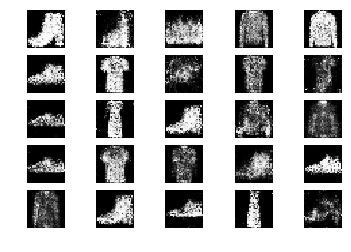

8401 [D loss: 0.644546, acc.: 65.62%] [G loss: 0.861430]
8402 [D loss: 0.590731, acc.: 71.88%] [G loss: 0.891675]
8403 [D loss: 0.661484, acc.: 62.50%] [G loss: 0.927628]
8404 [D loss: 0.664509, acc.: 62.50%] [G loss: 0.945868]
8405 [D loss: 0.632086, acc.: 64.06%] [G loss: 0.951644]
8406 [D loss: 0.615861, acc.: 64.06%] [G loss: 0.914751]
8407 [D loss: 0.610306, acc.: 76.56%] [G loss: 0.857107]
8408 [D loss: 0.588504, acc.: 70.31%] [G loss: 0.838724]
8409 [D loss: 0.701385, acc.: 46.88%] [G loss: 0.882447]
8410 [D loss: 0.679040, acc.: 56.25%] [G loss: 0.912550]
8411 [D loss: 0.685842, acc.: 56.25%] [G loss: 0.867658]
8412 [D loss: 0.597276, acc.: 67.19%] [G loss: 0.874989]
8413 [D loss: 0.620445, acc.: 65.62%] [G loss: 0.901951]
8414 [D loss: 0.660499, acc.: 60.94%] [G loss: 0.913875]
8415 [D loss: 0.655546, acc.: 59.38%] [G loss: 0.926107]
8416 [D loss: 0.656363, acc.: 60.94%] [G loss: 0.890985]
8417 [D loss: 0.684755, acc.: 60.94%] [G loss: 0.861546]
8418 [D loss: 0.582817, acc.: 7

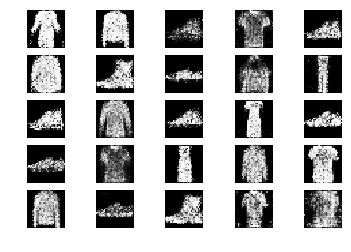

8601 [D loss: 0.623257, acc.: 71.88%] [G loss: 0.946049]
8602 [D loss: 0.668642, acc.: 54.69%] [G loss: 0.887745]
8603 [D loss: 0.677643, acc.: 65.62%] [G loss: 0.886017]
8604 [D loss: 0.684121, acc.: 62.50%] [G loss: 0.830530]
8605 [D loss: 0.656489, acc.: 57.81%] [G loss: 0.811334]
8606 [D loss: 0.637003, acc.: 57.81%] [G loss: 0.851467]
8607 [D loss: 0.604594, acc.: 68.75%] [G loss: 0.920279]
8608 [D loss: 0.727207, acc.: 54.69%] [G loss: 0.854416]
8609 [D loss: 0.675789, acc.: 56.25%] [G loss: 0.933542]
8610 [D loss: 0.673224, acc.: 60.94%] [G loss: 0.927262]
8611 [D loss: 0.738577, acc.: 48.44%] [G loss: 0.975654]
8612 [D loss: 0.623556, acc.: 68.75%] [G loss: 0.929418]
8613 [D loss: 0.631331, acc.: 68.75%] [G loss: 0.884134]
8614 [D loss: 0.702774, acc.: 53.12%] [G loss: 0.872278]
8615 [D loss: 0.617488, acc.: 75.00%] [G loss: 0.946191]
8616 [D loss: 0.656293, acc.: 62.50%] [G loss: 0.865747]
8617 [D loss: 0.618605, acc.: 68.75%] [G loss: 0.957323]
8618 [D loss: 0.715817, acc.: 4

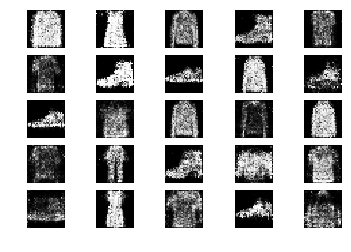

8801 [D loss: 0.637439, acc.: 62.50%] [G loss: 0.878874]
8802 [D loss: 0.571791, acc.: 73.44%] [G loss: 0.952758]
8803 [D loss: 0.655846, acc.: 60.94%] [G loss: 0.919396]
8804 [D loss: 0.646292, acc.: 60.94%] [G loss: 0.939326]
8805 [D loss: 0.650235, acc.: 60.94%] [G loss: 0.943613]
8806 [D loss: 0.683034, acc.: 57.81%] [G loss: 0.874211]
8807 [D loss: 0.615474, acc.: 65.62%] [G loss: 0.944497]
8808 [D loss: 0.654354, acc.: 60.94%] [G loss: 0.951041]
8809 [D loss: 0.656823, acc.: 56.25%] [G loss: 0.861836]
8810 [D loss: 0.629610, acc.: 65.62%] [G loss: 0.880790]
8811 [D loss: 0.660789, acc.: 60.94%] [G loss: 0.884308]
8812 [D loss: 0.652331, acc.: 62.50%] [G loss: 0.883674]
8813 [D loss: 0.558180, acc.: 79.69%] [G loss: 0.921158]
8814 [D loss: 0.643534, acc.: 57.81%] [G loss: 1.048050]
8815 [D loss: 0.628355, acc.: 65.62%] [G loss: 0.902565]
8816 [D loss: 0.621800, acc.: 65.62%] [G loss: 0.873523]
8817 [D loss: 0.667443, acc.: 62.50%] [G loss: 0.857928]
8818 [D loss: 0.622349, acc.: 7

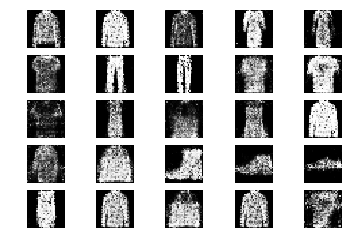

9001 [D loss: 0.760767, acc.: 46.88%] [G loss: 0.848614]
9002 [D loss: 0.668025, acc.: 53.12%] [G loss: 0.907786]
9003 [D loss: 0.649912, acc.: 60.94%] [G loss: 0.981638]
9004 [D loss: 0.601618, acc.: 62.50%] [G loss: 1.024544]
9005 [D loss: 0.655207, acc.: 60.94%] [G loss: 0.945403]
9006 [D loss: 0.663045, acc.: 59.38%] [G loss: 0.929718]
9007 [D loss: 0.621252, acc.: 70.31%] [G loss: 0.895153]
9008 [D loss: 0.661540, acc.: 56.25%] [G loss: 0.912550]
9009 [D loss: 0.555558, acc.: 78.12%] [G loss: 0.892550]
9010 [D loss: 0.680497, acc.: 57.81%] [G loss: 0.886077]
9011 [D loss: 0.640945, acc.: 68.75%] [G loss: 0.894967]
9012 [D loss: 0.644675, acc.: 62.50%] [G loss: 0.867910]
9013 [D loss: 0.654706, acc.: 57.81%] [G loss: 0.977869]
9014 [D loss: 0.570517, acc.: 75.00%] [G loss: 0.858719]
9015 [D loss: 0.650189, acc.: 57.81%] [G loss: 0.901403]
9016 [D loss: 0.613804, acc.: 65.62%] [G loss: 0.886621]
9017 [D loss: 0.682735, acc.: 59.38%] [G loss: 0.873969]
9018 [D loss: 0.702513, acc.: 5

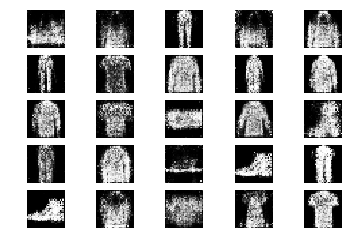

9201 [D loss: 0.665152, acc.: 64.06%] [G loss: 0.964661]
9202 [D loss: 0.698422, acc.: 56.25%] [G loss: 0.907789]
9203 [D loss: 0.680238, acc.: 56.25%] [G loss: 0.939443]
9204 [D loss: 0.683776, acc.: 56.25%] [G loss: 0.879811]
9205 [D loss: 0.587081, acc.: 76.56%] [G loss: 0.831707]
9206 [D loss: 0.672794, acc.: 62.50%] [G loss: 0.914242]
9207 [D loss: 0.676047, acc.: 57.81%] [G loss: 0.870900]
9208 [D loss: 0.589258, acc.: 68.75%] [G loss: 0.865472]
9209 [D loss: 0.679895, acc.: 56.25%] [G loss: 0.909998]
9210 [D loss: 0.646646, acc.: 57.81%] [G loss: 0.899614]
9211 [D loss: 0.723461, acc.: 54.69%] [G loss: 0.854214]
9212 [D loss: 0.650489, acc.: 62.50%] [G loss: 0.862589]
9213 [D loss: 0.613144, acc.: 70.31%] [G loss: 0.909375]
9214 [D loss: 0.626645, acc.: 62.50%] [G loss: 0.943590]
9215 [D loss: 0.605334, acc.: 70.31%] [G loss: 0.858378]
9216 [D loss: 0.588393, acc.: 70.31%] [G loss: 0.867069]
9217 [D loss: 0.655132, acc.: 62.50%] [G loss: 0.894781]
9218 [D loss: 0.625787, acc.: 6

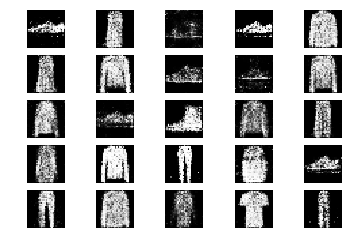

9401 [D loss: 0.639711, acc.: 65.62%] [G loss: 0.863326]
9402 [D loss: 0.657885, acc.: 60.94%] [G loss: 0.865890]
9403 [D loss: 0.641253, acc.: 64.06%] [G loss: 0.931094]
9404 [D loss: 0.666467, acc.: 60.94%] [G loss: 0.914650]
9405 [D loss: 0.671437, acc.: 57.81%] [G loss: 0.918251]
9406 [D loss: 0.656860, acc.: 60.94%] [G loss: 0.952538]
9407 [D loss: 0.680380, acc.: 62.50%] [G loss: 0.933326]
9408 [D loss: 0.631169, acc.: 65.62%] [G loss: 0.919428]
9409 [D loss: 0.691146, acc.: 51.56%] [G loss: 0.835937]
9410 [D loss: 0.680473, acc.: 62.50%] [G loss: 0.875768]
9411 [D loss: 0.608577, acc.: 68.75%] [G loss: 0.966142]
9412 [D loss: 0.674250, acc.: 60.94%] [G loss: 0.863700]
9413 [D loss: 0.676652, acc.: 59.38%] [G loss: 0.917142]
9414 [D loss: 0.665708, acc.: 56.25%] [G loss: 0.903165]
9415 [D loss: 0.686025, acc.: 54.69%] [G loss: 0.916952]
9416 [D loss: 0.631039, acc.: 59.38%] [G loss: 0.902249]
9417 [D loss: 0.677064, acc.: 54.69%] [G loss: 0.859721]
9418 [D loss: 0.615336, acc.: 6

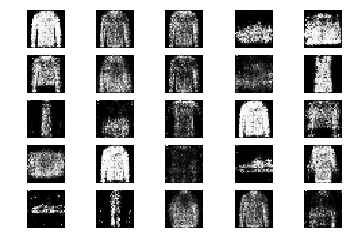

9601 [D loss: 0.691371, acc.: 51.56%] [G loss: 0.830163]
9602 [D loss: 0.634031, acc.: 65.62%] [G loss: 0.769345]
9603 [D loss: 0.709737, acc.: 46.88%] [G loss: 0.711817]
9604 [D loss: 0.658940, acc.: 65.62%] [G loss: 0.842364]
9605 [D loss: 0.679550, acc.: 59.38%] [G loss: 0.809500]
9606 [D loss: 0.658000, acc.: 57.81%] [G loss: 0.849744]
9607 [D loss: 0.661852, acc.: 56.25%] [G loss: 0.861231]
9608 [D loss: 0.676938, acc.: 62.50%] [G loss: 0.844003]
9609 [D loss: 0.686054, acc.: 62.50%] [G loss: 0.925325]
9610 [D loss: 0.669623, acc.: 56.25%] [G loss: 0.877087]
9611 [D loss: 0.658217, acc.: 57.81%] [G loss: 0.945256]
9612 [D loss: 0.642186, acc.: 60.94%] [G loss: 0.905456]
9613 [D loss: 0.640781, acc.: 60.94%] [G loss: 0.880095]
9614 [D loss: 0.635670, acc.: 64.06%] [G loss: 0.922544]
9615 [D loss: 0.631846, acc.: 64.06%] [G loss: 0.869447]
9616 [D loss: 0.679762, acc.: 53.12%] [G loss: 0.878694]
9617 [D loss: 0.697787, acc.: 46.88%] [G loss: 0.895831]
9618 [D loss: 0.664167, acc.: 5

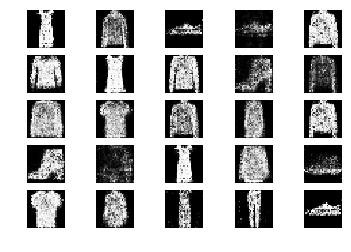

9801 [D loss: 0.626336, acc.: 65.62%] [G loss: 0.820001]
9802 [D loss: 0.596467, acc.: 68.75%] [G loss: 0.882888]
9803 [D loss: 0.675435, acc.: 60.94%] [G loss: 0.923576]
9804 [D loss: 0.593274, acc.: 64.06%] [G loss: 0.828706]
9805 [D loss: 0.717936, acc.: 53.12%] [G loss: 0.799134]
9806 [D loss: 0.682244, acc.: 59.38%] [G loss: 0.871934]
9807 [D loss: 0.695270, acc.: 62.50%] [G loss: 0.886449]
9808 [D loss: 0.681370, acc.: 60.94%] [G loss: 0.992891]
9809 [D loss: 0.646978, acc.: 67.19%] [G loss: 0.980262]
9810 [D loss: 0.693404, acc.: 57.81%] [G loss: 0.841740]
9811 [D loss: 0.616621, acc.: 62.50%] [G loss: 0.930547]
9812 [D loss: 0.658606, acc.: 64.06%] [G loss: 0.864241]
9813 [D loss: 0.658981, acc.: 56.25%] [G loss: 0.875584]
9814 [D loss: 0.709694, acc.: 53.12%] [G loss: 0.841704]
9815 [D loss: 0.678870, acc.: 59.38%] [G loss: 0.939797]
9816 [D loss: 0.636799, acc.: 57.81%] [G loss: 0.910880]
9817 [D loss: 0.670398, acc.: 54.69%] [G loss: 0.931152]
9818 [D loss: 0.652795, acc.: 6

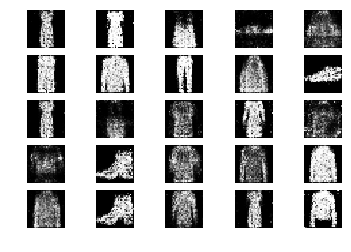

10001 [D loss: 0.677667, acc.: 59.38%] [G loss: 0.952025]
10002 [D loss: 0.668634, acc.: 59.38%] [G loss: 0.891819]
10003 [D loss: 0.638693, acc.: 64.06%] [G loss: 0.880174]
10004 [D loss: 0.629129, acc.: 64.06%] [G loss: 0.852277]
10005 [D loss: 0.659799, acc.: 59.38%] [G loss: 0.868326]
10006 [D loss: 0.692533, acc.: 59.38%] [G loss: 0.875194]
10007 [D loss: 0.648906, acc.: 62.50%] [G loss: 0.898965]
10008 [D loss: 0.626170, acc.: 62.50%] [G loss: 0.813162]
10009 [D loss: 0.630120, acc.: 62.50%] [G loss: 0.824946]
10010 [D loss: 0.635251, acc.: 67.19%] [G loss: 0.827099]
10011 [D loss: 0.602907, acc.: 68.75%] [G loss: 0.895864]
10012 [D loss: 0.690569, acc.: 56.25%] [G loss: 0.868789]
10013 [D loss: 0.680281, acc.: 51.56%] [G loss: 0.851369]
10014 [D loss: 0.640335, acc.: 65.62%] [G loss: 0.907230]
10015 [D loss: 0.606226, acc.: 75.00%] [G loss: 0.893802]
10016 [D loss: 0.672227, acc.: 57.81%] [G loss: 0.944510]
10017 [D loss: 0.606779, acc.: 68.75%] [G loss: 0.933362]
10018 [D loss:

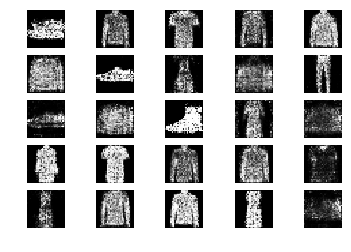

10201 [D loss: 0.760804, acc.: 46.88%] [G loss: 0.869002]
10202 [D loss: 0.670304, acc.: 57.81%] [G loss: 0.978828]
10203 [D loss: 0.609659, acc.: 71.88%] [G loss: 0.918614]
10204 [D loss: 0.674896, acc.: 67.19%] [G loss: 0.898226]
10205 [D loss: 0.693980, acc.: 57.81%] [G loss: 0.917941]
10206 [D loss: 0.650796, acc.: 64.06%] [G loss: 1.052330]
10207 [D loss: 0.628658, acc.: 60.94%] [G loss: 0.917404]
10208 [D loss: 0.664325, acc.: 57.81%] [G loss: 1.001998]
10209 [D loss: 0.675417, acc.: 65.62%] [G loss: 0.851990]
10210 [D loss: 0.733321, acc.: 46.88%] [G loss: 0.827501]
10211 [D loss: 0.591456, acc.: 73.44%] [G loss: 0.835738]
10212 [D loss: 0.667995, acc.: 53.12%] [G loss: 0.861256]
10213 [D loss: 0.646457, acc.: 62.50%] [G loss: 0.851447]
10214 [D loss: 0.629875, acc.: 62.50%] [G loss: 0.805923]
10215 [D loss: 0.670100, acc.: 62.50%] [G loss: 0.837512]
10216 [D loss: 0.653139, acc.: 59.38%] [G loss: 0.909558]
10217 [D loss: 0.606377, acc.: 68.75%] [G loss: 0.836101]
10218 [D loss:

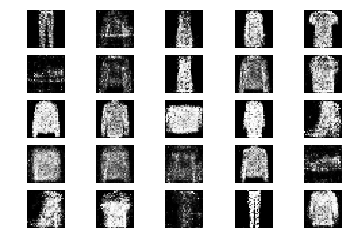

10401 [D loss: 0.620474, acc.: 68.75%] [G loss: 0.909268]
10402 [D loss: 0.619170, acc.: 64.06%] [G loss: 0.876280]
10403 [D loss: 0.678858, acc.: 57.81%] [G loss: 0.852793]
10404 [D loss: 0.728435, acc.: 45.31%] [G loss: 0.833499]
10405 [D loss: 0.632544, acc.: 60.94%] [G loss: 0.844275]
10406 [D loss: 0.705114, acc.: 46.88%] [G loss: 0.847871]
10407 [D loss: 0.684834, acc.: 54.69%] [G loss: 0.830780]
10408 [D loss: 0.598847, acc.: 64.06%] [G loss: 0.948251]
10409 [D loss: 0.637700, acc.: 59.38%] [G loss: 1.015607]
10410 [D loss: 0.656915, acc.: 53.12%] [G loss: 0.894509]
10411 [D loss: 0.610098, acc.: 65.62%] [G loss: 0.938690]
10412 [D loss: 0.699032, acc.: 60.94%] [G loss: 0.889808]
10413 [D loss: 0.616656, acc.: 64.06%] [G loss: 0.984860]
10414 [D loss: 0.616639, acc.: 67.19%] [G loss: 0.891600]
10415 [D loss: 0.640909, acc.: 62.50%] [G loss: 0.956321]
10416 [D loss: 0.631868, acc.: 62.50%] [G loss: 0.891265]
10417 [D loss: 0.663895, acc.: 51.56%] [G loss: 0.834318]
10418 [D loss:

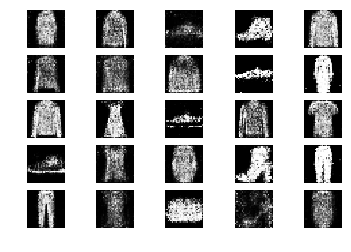

10601 [D loss: 0.630459, acc.: 67.19%] [G loss: 0.922582]
10602 [D loss: 0.633331, acc.: 60.94%] [G loss: 0.844398]
10603 [D loss: 0.656785, acc.: 57.81%] [G loss: 0.849227]
10604 [D loss: 0.644173, acc.: 67.19%] [G loss: 0.858568]
10605 [D loss: 0.603655, acc.: 68.75%] [G loss: 0.908926]
10606 [D loss: 0.659947, acc.: 59.38%] [G loss: 0.882433]
10607 [D loss: 0.628161, acc.: 60.94%] [G loss: 1.013262]
10608 [D loss: 0.638162, acc.: 70.31%] [G loss: 0.916316]
10609 [D loss: 0.697091, acc.: 60.94%] [G loss: 0.817014]
10610 [D loss: 0.697566, acc.: 48.44%] [G loss: 0.926240]
10611 [D loss: 0.685187, acc.: 54.69%] [G loss: 0.821924]
10612 [D loss: 0.620904, acc.: 65.62%] [G loss: 0.866317]
10613 [D loss: 0.652003, acc.: 62.50%] [G loss: 0.857727]
10614 [D loss: 0.696617, acc.: 53.12%] [G loss: 0.958730]
10615 [D loss: 0.689296, acc.: 48.44%] [G loss: 0.860068]
10616 [D loss: 0.660575, acc.: 54.69%] [G loss: 0.890077]
10617 [D loss: 0.599147, acc.: 71.88%] [G loss: 0.913311]
10618 [D loss:

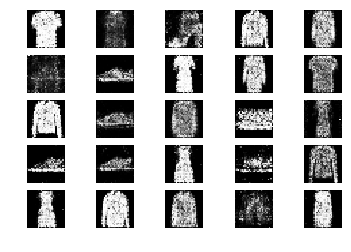

10801 [D loss: 0.615365, acc.: 65.62%] [G loss: 1.046618]
10802 [D loss: 0.692186, acc.: 56.25%] [G loss: 0.972073]
10803 [D loss: 0.689853, acc.: 53.12%] [G loss: 0.917871]
10804 [D loss: 0.672804, acc.: 54.69%] [G loss: 0.908176]
10805 [D loss: 0.562094, acc.: 75.00%] [G loss: 0.941792]
10806 [D loss: 0.600058, acc.: 68.75%] [G loss: 0.925523]
10807 [D loss: 0.702686, acc.: 51.56%] [G loss: 0.913157]
10808 [D loss: 0.686309, acc.: 53.12%] [G loss: 0.880835]
10809 [D loss: 0.628234, acc.: 68.75%] [G loss: 0.892607]
10810 [D loss: 0.575845, acc.: 75.00%] [G loss: 0.924001]
10811 [D loss: 0.641387, acc.: 65.62%] [G loss: 0.905733]
10812 [D loss: 0.657382, acc.: 57.81%] [G loss: 0.759061]
10813 [D loss: 0.611746, acc.: 71.88%] [G loss: 0.834040]
10814 [D loss: 0.573820, acc.: 71.88%] [G loss: 0.871582]
10815 [D loss: 0.654790, acc.: 54.69%] [G loss: 0.828707]
10816 [D loss: 0.699662, acc.: 56.25%] [G loss: 0.997645]
10817 [D loss: 0.642106, acc.: 67.19%] [G loss: 0.931684]
10818 [D loss:

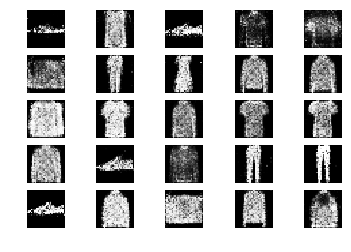

11001 [D loss: 0.675560, acc.: 56.25%] [G loss: 0.928882]
11002 [D loss: 0.607279, acc.: 68.75%] [G loss: 0.861116]
11003 [D loss: 0.650220, acc.: 62.50%] [G loss: 0.818371]
11004 [D loss: 0.633303, acc.: 60.94%] [G loss: 0.866007]
11005 [D loss: 0.663862, acc.: 57.81%] [G loss: 0.907391]
11006 [D loss: 0.622281, acc.: 59.38%] [G loss: 1.002304]
11007 [D loss: 0.648685, acc.: 59.38%] [G loss: 0.942133]
11008 [D loss: 0.680926, acc.: 51.56%] [G loss: 1.049651]
11009 [D loss: 0.640050, acc.: 64.06%] [G loss: 0.849999]
11010 [D loss: 0.684099, acc.: 60.94%] [G loss: 0.822204]
11011 [D loss: 0.649235, acc.: 60.94%] [G loss: 0.837443]
11012 [D loss: 0.677353, acc.: 67.19%] [G loss: 0.867241]
11013 [D loss: 0.662301, acc.: 59.38%] [G loss: 0.879461]
11014 [D loss: 0.656403, acc.: 54.69%] [G loss: 0.935212]
11015 [D loss: 0.638240, acc.: 60.94%] [G loss: 0.878509]
11016 [D loss: 0.681885, acc.: 56.25%] [G loss: 0.903973]
11017 [D loss: 0.651755, acc.: 57.81%] [G loss: 0.888482]
11018 [D loss:

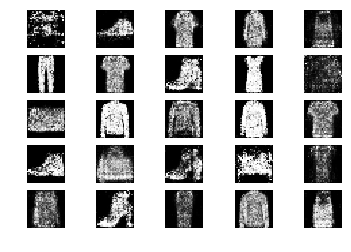

11201 [D loss: 0.671765, acc.: 56.25%] [G loss: 0.965621]
11202 [D loss: 0.628765, acc.: 67.19%] [G loss: 0.910896]
11203 [D loss: 0.591088, acc.: 70.31%] [G loss: 0.839422]
11204 [D loss: 0.630788, acc.: 67.19%] [G loss: 0.921971]
11205 [D loss: 0.713489, acc.: 48.44%] [G loss: 0.911731]
11206 [D loss: 0.703993, acc.: 54.69%] [G loss: 0.854158]
11207 [D loss: 0.672444, acc.: 60.94%] [G loss: 0.854807]
11208 [D loss: 0.687334, acc.: 53.12%] [G loss: 0.859609]
11209 [D loss: 0.651877, acc.: 64.06%] [G loss: 0.944426]
11210 [D loss: 0.627269, acc.: 65.62%] [G loss: 0.882365]
11211 [D loss: 0.708273, acc.: 53.12%] [G loss: 0.896139]
11212 [D loss: 0.620940, acc.: 65.62%] [G loss: 0.896121]
11213 [D loss: 0.657873, acc.: 59.38%] [G loss: 0.886626]
11214 [D loss: 0.698829, acc.: 57.81%] [G loss: 0.959123]
11215 [D loss: 0.629107, acc.: 64.06%] [G loss: 0.940768]
11216 [D loss: 0.652890, acc.: 57.81%] [G loss: 0.989528]
11217 [D loss: 0.680395, acc.: 62.50%] [G loss: 0.962130]
11218 [D loss:

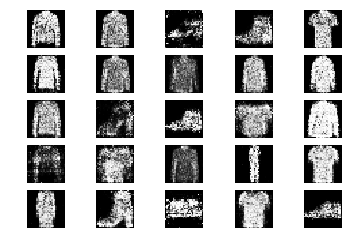

11401 [D loss: 0.695737, acc.: 60.94%] [G loss: 0.974487]
11402 [D loss: 0.683139, acc.: 56.25%] [G loss: 0.900434]
11403 [D loss: 0.605611, acc.: 71.88%] [G loss: 0.908475]
11404 [D loss: 0.577623, acc.: 67.19%] [G loss: 0.922456]
11405 [D loss: 0.593155, acc.: 70.31%] [G loss: 0.859061]
11406 [D loss: 0.739541, acc.: 54.69%] [G loss: 0.891060]
11407 [D loss: 0.729752, acc.: 53.12%] [G loss: 0.929376]
11408 [D loss: 0.616179, acc.: 65.62%] [G loss: 1.035285]
11409 [D loss: 0.690611, acc.: 65.62%] [G loss: 0.886361]
11410 [D loss: 0.656156, acc.: 65.62%] [G loss: 0.853039]
11411 [D loss: 0.653099, acc.: 59.38%] [G loss: 0.877885]
11412 [D loss: 0.608131, acc.: 67.19%] [G loss: 0.981103]
11413 [D loss: 0.672158, acc.: 53.12%] [G loss: 0.866787]
11414 [D loss: 0.690914, acc.: 57.81%] [G loss: 0.892930]
11415 [D loss: 0.647040, acc.: 62.50%] [G loss: 0.838198]
11416 [D loss: 0.666963, acc.: 60.94%] [G loss: 0.940276]
11417 [D loss: 0.707077, acc.: 59.38%] [G loss: 0.885574]
11418 [D loss:

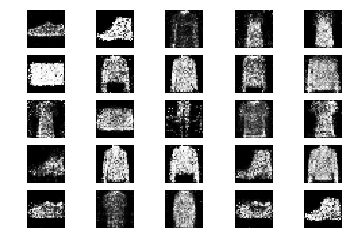

11601 [D loss: 0.640391, acc.: 62.50%] [G loss: 0.954459]
11602 [D loss: 0.726942, acc.: 53.12%] [G loss: 0.923701]
11603 [D loss: 0.692855, acc.: 57.81%] [G loss: 0.910826]
11604 [D loss: 0.713399, acc.: 48.44%] [G loss: 0.931816]
11605 [D loss: 0.691792, acc.: 53.12%] [G loss: 0.957491]
11606 [D loss: 0.697636, acc.: 50.00%] [G loss: 0.914179]
11607 [D loss: 0.603372, acc.: 70.31%] [G loss: 0.952126]
11608 [D loss: 0.684099, acc.: 56.25%] [G loss: 0.871915]
11609 [D loss: 0.709194, acc.: 43.75%] [G loss: 0.833314]
11610 [D loss: 0.642226, acc.: 53.12%] [G loss: 0.857984]
11611 [D loss: 0.648813, acc.: 64.06%] [G loss: 0.896649]
11612 [D loss: 0.592576, acc.: 73.44%] [G loss: 0.909016]
11613 [D loss: 0.661754, acc.: 56.25%] [G loss: 0.840999]
11614 [D loss: 0.633661, acc.: 65.62%] [G loss: 0.914977]
11615 [D loss: 0.622373, acc.: 64.06%] [G loss: 0.893192]
11616 [D loss: 0.647520, acc.: 68.75%] [G loss: 0.920711]
11617 [D loss: 0.632448, acc.: 71.88%] [G loss: 0.940267]
11618 [D loss:

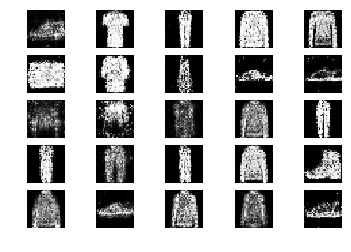

11801 [D loss: 0.661837, acc.: 62.50%] [G loss: 0.927736]
11802 [D loss: 0.584964, acc.: 78.12%] [G loss: 0.891435]
11803 [D loss: 0.657615, acc.: 59.38%] [G loss: 0.943564]
11804 [D loss: 0.634861, acc.: 65.62%] [G loss: 0.898307]
11805 [D loss: 0.622519, acc.: 73.44%] [G loss: 0.852271]
11806 [D loss: 0.593752, acc.: 73.44%] [G loss: 0.890919]
11807 [D loss: 0.615224, acc.: 73.44%] [G loss: 0.877392]
11808 [D loss: 0.666089, acc.: 62.50%] [G loss: 0.839629]
11809 [D loss: 0.699612, acc.: 51.56%] [G loss: 0.918869]
11810 [D loss: 0.693496, acc.: 60.94%] [G loss: 0.894029]
11811 [D loss: 0.686273, acc.: 56.25%] [G loss: 0.905919]
11812 [D loss: 0.658246, acc.: 65.62%] [G loss: 0.933033]
11813 [D loss: 0.590282, acc.: 70.31%] [G loss: 0.887217]
11814 [D loss: 0.670869, acc.: 60.94%] [G loss: 0.848310]
11815 [D loss: 0.604038, acc.: 70.31%] [G loss: 0.896050]
11816 [D loss: 0.630571, acc.: 64.06%] [G loss: 0.928805]
11817 [D loss: 0.627099, acc.: 67.19%] [G loss: 0.897993]
11818 [D loss:

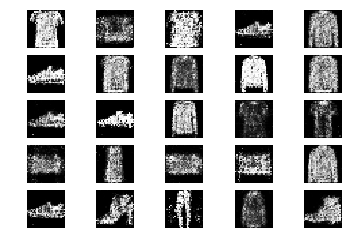

12001 [D loss: 0.664015, acc.: 62.50%] [G loss: 0.846964]
12002 [D loss: 0.640671, acc.: 60.94%] [G loss: 0.854345]
12003 [D loss: 0.612449, acc.: 68.75%] [G loss: 0.935348]
12004 [D loss: 0.622063, acc.: 68.75%] [G loss: 0.856556]
12005 [D loss: 0.652757, acc.: 57.81%] [G loss: 0.821138]
12006 [D loss: 0.622474, acc.: 62.50%] [G loss: 0.824557]
12007 [D loss: 0.611156, acc.: 68.75%] [G loss: 0.832998]
12008 [D loss: 0.641449, acc.: 60.94%] [G loss: 0.829084]
12009 [D loss: 0.629172, acc.: 68.75%] [G loss: 0.886582]
12010 [D loss: 0.666258, acc.: 60.94%] [G loss: 0.967196]
12011 [D loss: 0.674331, acc.: 54.69%] [G loss: 0.872419]
12012 [D loss: 0.677172, acc.: 56.25%] [G loss: 0.933475]
12013 [D loss: 0.671020, acc.: 56.25%] [G loss: 0.871654]
12014 [D loss: 0.632239, acc.: 65.62%] [G loss: 0.871832]
12015 [D loss: 0.644122, acc.: 60.94%] [G loss: 0.904118]
12016 [D loss: 0.743490, acc.: 42.19%] [G loss: 0.951889]
12017 [D loss: 0.643614, acc.: 60.94%] [G loss: 0.889361]
12018 [D loss:

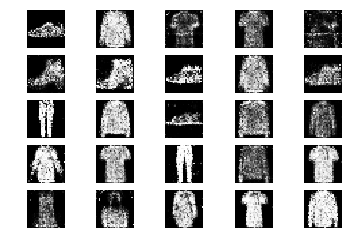

12201 [D loss: 0.599299, acc.: 65.62%] [G loss: 0.919558]
12202 [D loss: 0.627800, acc.: 64.06%] [G loss: 0.834702]
12203 [D loss: 0.620723, acc.: 70.31%] [G loss: 0.910144]
12204 [D loss: 0.656992, acc.: 68.75%] [G loss: 0.895089]
12205 [D loss: 0.688449, acc.: 54.69%] [G loss: 0.972073]
12206 [D loss: 0.575610, acc.: 81.25%] [G loss: 0.857115]
12207 [D loss: 0.650134, acc.: 54.69%] [G loss: 0.926050]
12208 [D loss: 0.654923, acc.: 67.19%] [G loss: 0.886666]
12209 [D loss: 0.652090, acc.: 60.94%] [G loss: 0.812473]
12210 [D loss: 0.642210, acc.: 57.81%] [G loss: 0.885340]
12211 [D loss: 0.691971, acc.: 56.25%] [G loss: 0.808821]
12212 [D loss: 0.655031, acc.: 57.81%] [G loss: 0.839958]
12213 [D loss: 0.719466, acc.: 50.00%] [G loss: 0.915302]
12214 [D loss: 0.601160, acc.: 73.44%] [G loss: 0.950554]
12215 [D loss: 0.634329, acc.: 65.62%] [G loss: 0.986441]
12216 [D loss: 0.720585, acc.: 46.88%] [G loss: 0.914750]
12217 [D loss: 0.657961, acc.: 56.25%] [G loss: 0.897766]
12218 [D loss:

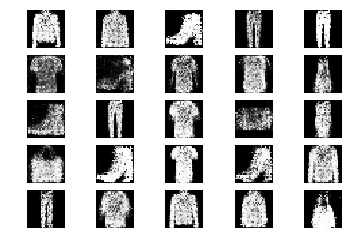

12401 [D loss: 0.637578, acc.: 67.19%] [G loss: 0.827571]
12402 [D loss: 0.640794, acc.: 62.50%] [G loss: 0.893000]
12403 [D loss: 0.636681, acc.: 57.81%] [G loss: 0.888200]
12404 [D loss: 0.665606, acc.: 60.94%] [G loss: 0.915597]
12405 [D loss: 0.589800, acc.: 68.75%] [G loss: 0.941045]
12406 [D loss: 0.682709, acc.: 59.38%] [G loss: 0.899708]
12407 [D loss: 0.705020, acc.: 56.25%] [G loss: 0.984720]
12408 [D loss: 0.628479, acc.: 71.88%] [G loss: 0.957986]
12409 [D loss: 0.621551, acc.: 68.75%] [G loss: 0.971313]
12410 [D loss: 0.704276, acc.: 51.56%] [G loss: 0.948299]
12411 [D loss: 0.699651, acc.: 50.00%] [G loss: 0.868131]
12412 [D loss: 0.647781, acc.: 60.94%] [G loss: 0.856646]
12413 [D loss: 0.689328, acc.: 57.81%] [G loss: 0.968736]
12414 [D loss: 0.585244, acc.: 70.31%] [G loss: 0.893027]
12415 [D loss: 0.670199, acc.: 53.12%] [G loss: 0.973508]
12416 [D loss: 0.634724, acc.: 65.62%] [G loss: 0.828209]
12417 [D loss: 0.720036, acc.: 56.25%] [G loss: 0.883375]
12418 [D loss:

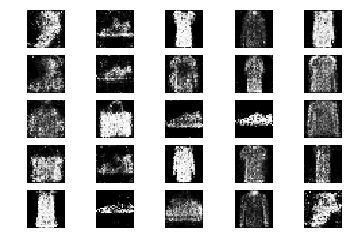

12601 [D loss: 0.620686, acc.: 68.75%] [G loss: 0.812065]
12602 [D loss: 0.577496, acc.: 70.31%] [G loss: 0.838815]
12603 [D loss: 0.632638, acc.: 60.94%] [G loss: 0.880883]
12604 [D loss: 0.653205, acc.: 60.94%] [G loss: 0.934355]
12605 [D loss: 0.614487, acc.: 67.19%] [G loss: 0.840800]
12606 [D loss: 0.629164, acc.: 65.62%] [G loss: 0.924112]
12607 [D loss: 0.681920, acc.: 56.25%] [G loss: 0.919726]
12608 [D loss: 0.682195, acc.: 57.81%] [G loss: 0.823883]
12609 [D loss: 0.623571, acc.: 64.06%] [G loss: 0.924612]
12610 [D loss: 0.661729, acc.: 59.38%] [G loss: 0.895198]
12611 [D loss: 0.653147, acc.: 67.19%] [G loss: 0.850288]
12612 [D loss: 0.704166, acc.: 56.25%] [G loss: 0.922200]
12613 [D loss: 0.609534, acc.: 65.62%] [G loss: 0.986072]
12614 [D loss: 0.628309, acc.: 64.06%] [G loss: 0.930467]
12615 [D loss: 0.665871, acc.: 57.81%] [G loss: 0.970242]
12616 [D loss: 0.638195, acc.: 56.25%] [G loss: 0.959594]
12617 [D loss: 0.611417, acc.: 73.44%] [G loss: 1.041393]
12618 [D loss:

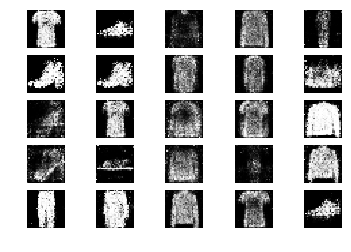

12801 [D loss: 0.582759, acc.: 76.56%] [G loss: 0.928743]
12802 [D loss: 0.670515, acc.: 54.69%] [G loss: 0.902923]
12803 [D loss: 0.620693, acc.: 64.06%] [G loss: 0.823014]
12804 [D loss: 0.630707, acc.: 67.19%] [G loss: 0.933232]
12805 [D loss: 0.695948, acc.: 50.00%] [G loss: 0.858941]
12806 [D loss: 0.749494, acc.: 45.31%] [G loss: 0.905065]
12807 [D loss: 0.641600, acc.: 64.06%] [G loss: 0.979411]
12808 [D loss: 0.575055, acc.: 64.06%] [G loss: 0.916920]
12809 [D loss: 0.644362, acc.: 54.69%] [G loss: 0.915907]
12810 [D loss: 0.676584, acc.: 50.00%] [G loss: 0.989349]
12811 [D loss: 0.631657, acc.: 64.06%] [G loss: 0.985328]
12812 [D loss: 0.604313, acc.: 70.31%] [G loss: 0.885439]
12813 [D loss: 0.701581, acc.: 48.44%] [G loss: 0.838628]
12814 [D loss: 0.630730, acc.: 62.50%] [G loss: 0.839890]
12815 [D loss: 0.619360, acc.: 67.19%] [G loss: 0.833706]
12816 [D loss: 0.658571, acc.: 60.94%] [G loss: 0.890308]
12817 [D loss: 0.665435, acc.: 56.25%] [G loss: 0.885001]
12818 [D loss:

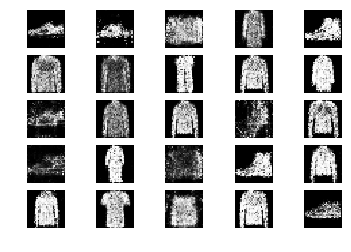

13001 [D loss: 0.693417, acc.: 56.25%] [G loss: 0.938497]
13002 [D loss: 0.645812, acc.: 65.62%] [G loss: 0.891615]
13003 [D loss: 0.622933, acc.: 67.19%] [G loss: 0.932098]
13004 [D loss: 0.659044, acc.: 65.62%] [G loss: 0.975865]
13005 [D loss: 0.662931, acc.: 57.81%] [G loss: 0.982815]
13006 [D loss: 0.614822, acc.: 62.50%] [G loss: 0.901127]
13007 [D loss: 0.695703, acc.: 59.38%] [G loss: 0.847653]
13008 [D loss: 0.678484, acc.: 62.50%] [G loss: 0.901208]
13009 [D loss: 0.658990, acc.: 59.38%] [G loss: 0.848208]
13010 [D loss: 0.615630, acc.: 67.19%] [G loss: 0.898216]
13011 [D loss: 0.614376, acc.: 65.62%] [G loss: 0.986627]
13012 [D loss: 0.683273, acc.: 53.12%] [G loss: 0.952967]
13013 [D loss: 0.635981, acc.: 60.94%] [G loss: 0.938810]
13014 [D loss: 0.683309, acc.: 54.69%] [G loss: 0.999853]
13015 [D loss: 0.623825, acc.: 65.62%] [G loss: 1.036185]
13016 [D loss: 0.650949, acc.: 56.25%] [G loss: 0.853453]
13017 [D loss: 0.634196, acc.: 62.50%] [G loss: 0.872173]
13018 [D loss:

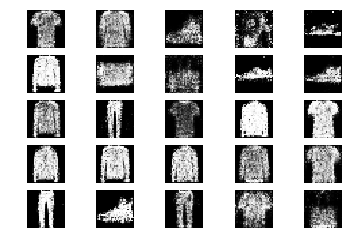

13201 [D loss: 0.632831, acc.: 59.38%] [G loss: 0.831954]
13202 [D loss: 0.734580, acc.: 56.25%] [G loss: 0.886789]
13203 [D loss: 0.652958, acc.: 57.81%] [G loss: 0.920702]
13204 [D loss: 0.687063, acc.: 60.94%] [G loss: 0.898850]
13205 [D loss: 0.658104, acc.: 54.69%] [G loss: 0.956451]
13206 [D loss: 0.663329, acc.: 57.81%] [G loss: 0.831281]
13207 [D loss: 0.619263, acc.: 70.31%] [G loss: 0.823012]
13208 [D loss: 0.641974, acc.: 62.50%] [G loss: 0.866720]
13209 [D loss: 0.666798, acc.: 59.38%] [G loss: 0.949493]
13210 [D loss: 0.642736, acc.: 64.06%] [G loss: 0.893462]
13211 [D loss: 0.603297, acc.: 68.75%] [G loss: 0.884762]
13212 [D loss: 0.618274, acc.: 68.75%] [G loss: 0.977176]
13213 [D loss: 0.671800, acc.: 62.50%] [G loss: 0.922421]
13214 [D loss: 0.668770, acc.: 54.69%] [G loss: 0.845169]
13215 [D loss: 0.651600, acc.: 57.81%] [G loss: 0.869910]
13216 [D loss: 0.659291, acc.: 57.81%] [G loss: 0.889304]
13217 [D loss: 0.716485, acc.: 51.56%] [G loss: 0.804704]
13218 [D loss:

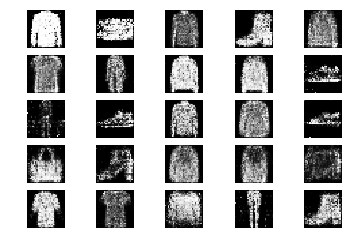

13401 [D loss: 0.615094, acc.: 73.44%] [G loss: 0.855996]
13402 [D loss: 0.617414, acc.: 67.19%] [G loss: 0.920472]
13403 [D loss: 0.609873, acc.: 64.06%] [G loss: 0.928064]
13404 [D loss: 0.695873, acc.: 56.25%] [G loss: 0.811388]
13405 [D loss: 0.625309, acc.: 67.19%] [G loss: 0.847336]
13406 [D loss: 0.621369, acc.: 68.75%] [G loss: 0.910835]
13407 [D loss: 0.640620, acc.: 57.81%] [G loss: 0.962218]
13408 [D loss: 0.662859, acc.: 60.94%] [G loss: 0.810906]
13409 [D loss: 0.672747, acc.: 54.69%] [G loss: 0.952246]
13410 [D loss: 0.650704, acc.: 60.94%] [G loss: 0.907795]
13411 [D loss: 0.664914, acc.: 54.69%] [G loss: 0.954245]
13412 [D loss: 0.723014, acc.: 46.88%] [G loss: 0.925941]
13413 [D loss: 0.646683, acc.: 57.81%] [G loss: 1.021874]
13414 [D loss: 0.642846, acc.: 60.94%] [G loss: 0.892025]
13415 [D loss: 0.647897, acc.: 53.12%] [G loss: 0.930037]
13416 [D loss: 0.627448, acc.: 64.06%] [G loss: 0.951390]
13417 [D loss: 0.635696, acc.: 68.75%] [G loss: 0.978126]
13418 [D loss:

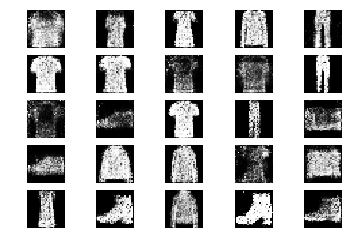

13601 [D loss: 0.634596, acc.: 65.62%] [G loss: 0.881902]
13602 [D loss: 0.689763, acc.: 50.00%] [G loss: 0.829009]
13603 [D loss: 0.671914, acc.: 56.25%] [G loss: 0.850320]
13604 [D loss: 0.653851, acc.: 56.25%] [G loss: 0.855814]
13605 [D loss: 0.680061, acc.: 53.12%] [G loss: 0.951703]
13606 [D loss: 0.656045, acc.: 53.12%] [G loss: 0.872768]
13607 [D loss: 0.697822, acc.: 59.38%] [G loss: 0.902187]
13608 [D loss: 0.626021, acc.: 70.31%] [G loss: 0.879854]
13609 [D loss: 0.664348, acc.: 62.50%] [G loss: 0.889592]
13610 [D loss: 0.701712, acc.: 54.69%] [G loss: 0.906788]
13611 [D loss: 0.677215, acc.: 53.12%] [G loss: 0.854835]
13612 [D loss: 0.724432, acc.: 53.12%] [G loss: 0.945062]
13613 [D loss: 0.638935, acc.: 62.50%] [G loss: 0.991478]
13614 [D loss: 0.768383, acc.: 46.88%] [G loss: 0.941246]
13615 [D loss: 0.663692, acc.: 56.25%] [G loss: 1.015509]
13616 [D loss: 0.692266, acc.: 57.81%] [G loss: 0.915665]
13617 [D loss: 0.658966, acc.: 64.06%] [G loss: 0.968017]
13618 [D loss:

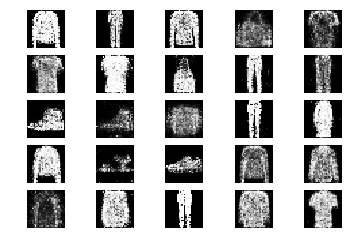

13801 [D loss: 0.616931, acc.: 65.62%] [G loss: 0.825004]
13802 [D loss: 0.602935, acc.: 70.31%] [G loss: 0.911102]
13803 [D loss: 0.628425, acc.: 62.50%] [G loss: 0.853417]
13804 [D loss: 0.631876, acc.: 67.19%] [G loss: 0.893993]
13805 [D loss: 0.578930, acc.: 71.88%] [G loss: 0.928126]
13806 [D loss: 0.705074, acc.: 54.69%] [G loss: 0.945019]
13807 [D loss: 0.660523, acc.: 60.94%] [G loss: 0.964109]
13808 [D loss: 0.641883, acc.: 53.12%] [G loss: 0.954788]
13809 [D loss: 0.638154, acc.: 65.62%] [G loss: 1.004509]
13810 [D loss: 0.634072, acc.: 67.19%] [G loss: 0.881356]
13811 [D loss: 0.665469, acc.: 65.62%] [G loss: 0.897919]
13812 [D loss: 0.661508, acc.: 64.06%] [G loss: 0.877355]
13813 [D loss: 0.663875, acc.: 48.44%] [G loss: 0.797910]
13814 [D loss: 0.636797, acc.: 56.25%] [G loss: 0.887950]
13815 [D loss: 0.684625, acc.: 56.25%] [G loss: 0.833511]
13816 [D loss: 0.650075, acc.: 59.38%] [G loss: 0.865803]
13817 [D loss: 0.729954, acc.: 48.44%] [G loss: 0.923337]
13818 [D loss:

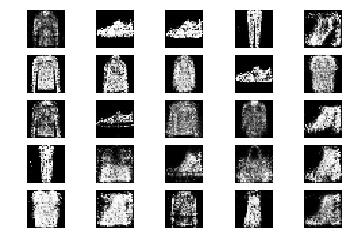

14001 [D loss: 0.689758, acc.: 48.44%] [G loss: 0.948143]
14002 [D loss: 0.661684, acc.: 56.25%] [G loss: 0.942469]
14003 [D loss: 0.621117, acc.: 64.06%] [G loss: 0.974196]
14004 [D loss: 0.744128, acc.: 53.12%] [G loss: 0.987199]
14005 [D loss: 0.708990, acc.: 48.44%] [G loss: 0.925617]
14006 [D loss: 0.665792, acc.: 59.38%] [G loss: 0.932734]
14007 [D loss: 0.654884, acc.: 64.06%] [G loss: 0.991509]
14008 [D loss: 0.678655, acc.: 57.81%] [G loss: 0.907229]
14009 [D loss: 0.631463, acc.: 64.06%] [G loss: 0.913885]
14010 [D loss: 0.657265, acc.: 62.50%] [G loss: 0.927986]
14011 [D loss: 0.618613, acc.: 65.62%] [G loss: 0.868894]
14012 [D loss: 0.669295, acc.: 59.38%] [G loss: 0.892146]
14013 [D loss: 0.647908, acc.: 67.19%] [G loss: 0.857497]
14014 [D loss: 0.645880, acc.: 62.50%] [G loss: 0.954524]
14015 [D loss: 0.604241, acc.: 68.75%] [G loss: 0.957674]
14016 [D loss: 0.676654, acc.: 56.25%] [G loss: 0.964305]
14017 [D loss: 0.659176, acc.: 62.50%] [G loss: 0.897797]
14018 [D loss:

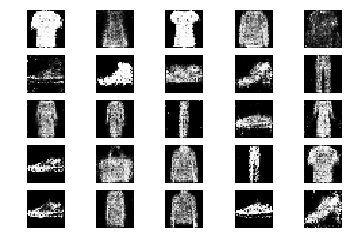

14201 [D loss: 0.625199, acc.: 65.62%] [G loss: 0.969103]
14202 [D loss: 0.624783, acc.: 68.75%] [G loss: 0.943519]
14203 [D loss: 0.688519, acc.: 54.69%] [G loss: 0.881936]
14204 [D loss: 0.606697, acc.: 67.19%] [G loss: 0.966921]
14205 [D loss: 0.634697, acc.: 65.62%] [G loss: 0.971970]
14206 [D loss: 0.657636, acc.: 65.62%] [G loss: 0.936130]
14207 [D loss: 0.629766, acc.: 59.38%] [G loss: 0.927261]
14208 [D loss: 0.629663, acc.: 64.06%] [G loss: 0.950025]
14209 [D loss: 0.700923, acc.: 51.56%] [G loss: 0.902336]
14210 [D loss: 0.607364, acc.: 64.06%] [G loss: 0.876940]
14211 [D loss: 0.694692, acc.: 54.69%] [G loss: 0.913998]
14212 [D loss: 0.644079, acc.: 68.75%] [G loss: 0.924889]
14213 [D loss: 0.649224, acc.: 59.38%] [G loss: 0.963587]
14214 [D loss: 0.641210, acc.: 65.62%] [G loss: 0.914759]
14215 [D loss: 0.712242, acc.: 53.12%] [G loss: 0.907658]
14216 [D loss: 0.703030, acc.: 50.00%] [G loss: 0.943421]
14217 [D loss: 0.642429, acc.: 67.19%] [G loss: 0.875216]
14218 [D loss:

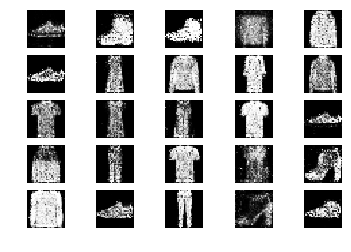

14401 [D loss: 0.604807, acc.: 71.88%] [G loss: 0.929106]
14402 [D loss: 0.635304, acc.: 57.81%] [G loss: 0.892515]
14403 [D loss: 0.640021, acc.: 68.75%] [G loss: 0.938538]
14404 [D loss: 0.667350, acc.: 65.62%] [G loss: 0.837684]
14405 [D loss: 0.646564, acc.: 62.50%] [G loss: 0.917925]
14406 [D loss: 0.711630, acc.: 53.12%] [G loss: 0.870832]
14407 [D loss: 0.664609, acc.: 60.94%] [G loss: 0.899644]
14408 [D loss: 0.671151, acc.: 60.94%] [G loss: 0.934075]
14409 [D loss: 0.645859, acc.: 62.50%] [G loss: 0.906350]
14410 [D loss: 0.605093, acc.: 73.44%] [G loss: 0.842163]
14411 [D loss: 0.643227, acc.: 65.62%] [G loss: 0.945166]
14412 [D loss: 0.668086, acc.: 70.31%] [G loss: 0.899563]
14413 [D loss: 0.581150, acc.: 71.88%] [G loss: 0.945524]
14414 [D loss: 0.681871, acc.: 64.06%] [G loss: 0.926004]
14415 [D loss: 0.637740, acc.: 67.19%] [G loss: 0.871987]
14416 [D loss: 0.667665, acc.: 67.19%] [G loss: 0.884756]
14417 [D loss: 0.690284, acc.: 48.44%] [G loss: 0.921432]
14418 [D loss:

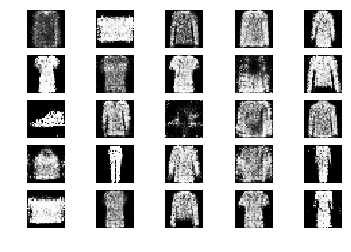

14601 [D loss: 0.665591, acc.: 64.06%] [G loss: 0.821548]
14602 [D loss: 0.672667, acc.: 54.69%] [G loss: 0.949190]
14603 [D loss: 0.705895, acc.: 60.94%] [G loss: 0.849627]
14604 [D loss: 0.603631, acc.: 68.75%] [G loss: 0.891381]
14605 [D loss: 0.705084, acc.: 65.62%] [G loss: 0.933345]
14606 [D loss: 0.637525, acc.: 64.06%] [G loss: 0.901847]
14607 [D loss: 0.664727, acc.: 59.38%] [G loss: 0.950627]
14608 [D loss: 0.727833, acc.: 48.44%] [G loss: 0.905812]
14609 [D loss: 0.666175, acc.: 51.56%] [G loss: 0.914757]
14610 [D loss: 0.624492, acc.: 62.50%] [G loss: 0.864935]
14611 [D loss: 0.670587, acc.: 54.69%] [G loss: 0.916281]
14612 [D loss: 0.690784, acc.: 51.56%] [G loss: 0.960083]
14613 [D loss: 0.637385, acc.: 59.38%] [G loss: 0.857529]
14614 [D loss: 0.619147, acc.: 65.62%] [G loss: 0.887855]
14615 [D loss: 0.640683, acc.: 59.38%] [G loss: 0.944089]
14616 [D loss: 0.636846, acc.: 62.50%] [G loss: 0.921865]
14617 [D loss: 0.641438, acc.: 59.38%] [G loss: 0.899099]
14618 [D loss:

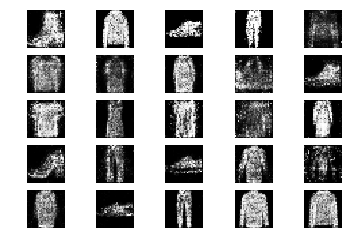

14801 [D loss: 0.693258, acc.: 60.94%] [G loss: 0.915008]
14802 [D loss: 0.631421, acc.: 67.19%] [G loss: 0.933198]
14803 [D loss: 0.629566, acc.: 67.19%] [G loss: 0.832352]
14804 [D loss: 0.679412, acc.: 54.69%] [G loss: 0.798185]
14805 [D loss: 0.634108, acc.: 67.19%] [G loss: 0.910200]
14806 [D loss: 0.761702, acc.: 51.56%] [G loss: 0.934924]
14807 [D loss: 0.633551, acc.: 71.88%] [G loss: 0.894940]
14808 [D loss: 0.613015, acc.: 65.62%] [G loss: 0.872555]
14809 [D loss: 0.559520, acc.: 76.56%] [G loss: 0.932427]
14810 [D loss: 0.658148, acc.: 59.38%] [G loss: 0.869199]
14811 [D loss: 0.634290, acc.: 54.69%] [G loss: 0.921250]
14812 [D loss: 0.683945, acc.: 60.94%] [G loss: 0.782960]
14813 [D loss: 0.675350, acc.: 59.38%] [G loss: 0.873632]
14814 [D loss: 0.648277, acc.: 65.62%] [G loss: 0.919734]
14815 [D loss: 0.621249, acc.: 68.75%] [G loss: 0.967987]
14816 [D loss: 0.671865, acc.: 56.25%] [G loss: 0.919285]
14817 [D loss: 0.661504, acc.: 57.81%] [G loss: 0.944148]
14818 [D loss:

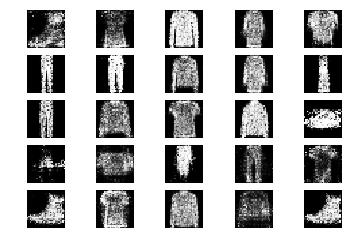

15001 [D loss: 0.665434, acc.: 65.62%] [G loss: 1.005113]
15002 [D loss: 0.680497, acc.: 62.50%] [G loss: 0.830905]
15003 [D loss: 0.618374, acc.: 64.06%] [G loss: 0.840772]
15004 [D loss: 0.656730, acc.: 62.50%] [G loss: 0.827749]
15005 [D loss: 0.724489, acc.: 48.44%] [G loss: 0.839767]
15006 [D loss: 0.606793, acc.: 65.62%] [G loss: 0.937686]
15007 [D loss: 0.653725, acc.: 57.81%] [G loss: 0.978627]
15008 [D loss: 0.652855, acc.: 65.62%] [G loss: 0.976269]
15009 [D loss: 0.674573, acc.: 56.25%] [G loss: 0.975838]
15010 [D loss: 0.601936, acc.: 62.50%] [G loss: 0.924053]
15011 [D loss: 0.665881, acc.: 62.50%] [G loss: 0.914330]
15012 [D loss: 0.615320, acc.: 68.75%] [G loss: 0.937830]
15013 [D loss: 0.599816, acc.: 67.19%] [G loss: 0.889178]
15014 [D loss: 0.619543, acc.: 65.62%] [G loss: 0.987850]
15015 [D loss: 0.651372, acc.: 57.81%] [G loss: 0.932467]
15016 [D loss: 0.631388, acc.: 70.31%] [G loss: 0.916975]
15017 [D loss: 0.680187, acc.: 56.25%] [G loss: 0.922261]
15018 [D loss:

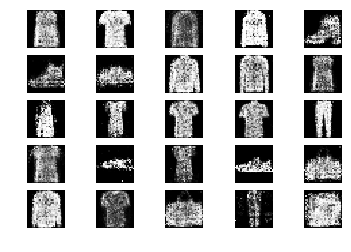

15201 [D loss: 0.657648, acc.: 60.94%] [G loss: 0.897844]
15202 [D loss: 0.661262, acc.: 57.81%] [G loss: 0.874371]
15203 [D loss: 0.656387, acc.: 60.94%] [G loss: 0.863472]
15204 [D loss: 0.642040, acc.: 67.19%] [G loss: 0.869646]
15205 [D loss: 0.594046, acc.: 67.19%] [G loss: 0.960106]
15206 [D loss: 0.647749, acc.: 60.94%] [G loss: 0.885899]
15207 [D loss: 0.524782, acc.: 84.38%] [G loss: 0.934197]
15208 [D loss: 0.613808, acc.: 56.25%] [G loss: 0.940435]
15209 [D loss: 0.639787, acc.: 67.19%] [G loss: 0.961600]
15210 [D loss: 0.678530, acc.: 54.69%] [G loss: 0.945151]
15211 [D loss: 0.586962, acc.: 71.88%] [G loss: 0.992645]
15212 [D loss: 0.593464, acc.: 75.00%] [G loss: 0.957217]
15213 [D loss: 0.659460, acc.: 64.06%] [G loss: 0.947028]
15214 [D loss: 0.642583, acc.: 64.06%] [G loss: 0.905990]
15215 [D loss: 0.602150, acc.: 65.62%] [G loss: 0.873228]
15216 [D loss: 0.582945, acc.: 70.31%] [G loss: 0.876686]
15217 [D loss: 0.612502, acc.: 68.75%] [G loss: 0.879189]
15218 [D loss:

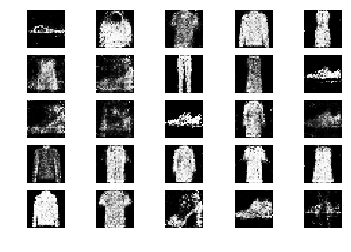

15401 [D loss: 0.621768, acc.: 73.44%] [G loss: 0.856889]
15402 [D loss: 0.637705, acc.: 59.38%] [G loss: 0.881561]
15403 [D loss: 0.612777, acc.: 68.75%] [G loss: 0.899837]
15404 [D loss: 0.603174, acc.: 67.19%] [G loss: 0.910870]
15405 [D loss: 0.714580, acc.: 54.69%] [G loss: 1.004075]
15406 [D loss: 0.611152, acc.: 76.56%] [G loss: 0.905719]
15407 [D loss: 0.673716, acc.: 51.56%] [G loss: 0.863336]
15408 [D loss: 0.571950, acc.: 73.44%] [G loss: 0.890656]
15409 [D loss: 0.669894, acc.: 56.25%] [G loss: 0.901578]
15410 [D loss: 0.693431, acc.: 53.12%] [G loss: 0.929606]
15411 [D loss: 0.647725, acc.: 59.38%] [G loss: 0.907333]
15412 [D loss: 0.639880, acc.: 62.50%] [G loss: 0.857707]
15413 [D loss: 0.708737, acc.: 42.19%] [G loss: 0.800643]
15414 [D loss: 0.659852, acc.: 57.81%] [G loss: 0.984103]
15415 [D loss: 0.709322, acc.: 50.00%] [G loss: 0.948204]
15416 [D loss: 0.655209, acc.: 64.06%] [G loss: 0.939641]
15417 [D loss: 0.666123, acc.: 56.25%] [G loss: 0.883195]
15418 [D loss:

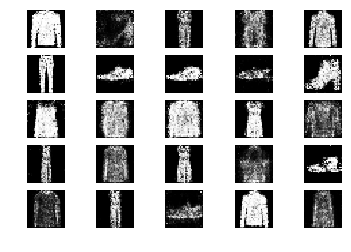

15601 [D loss: 0.657223, acc.: 64.06%] [G loss: 0.904350]
15602 [D loss: 0.612111, acc.: 67.19%] [G loss: 0.952756]
15603 [D loss: 0.646461, acc.: 62.50%] [G loss: 0.900074]
15604 [D loss: 0.610309, acc.: 65.62%] [G loss: 0.926365]
15605 [D loss: 0.641043, acc.: 57.81%] [G loss: 0.963111]
15606 [D loss: 0.620838, acc.: 67.19%] [G loss: 0.835025]
15607 [D loss: 0.656209, acc.: 54.69%] [G loss: 0.847862]
15608 [D loss: 0.707724, acc.: 53.12%] [G loss: 0.897208]
15609 [D loss: 0.628553, acc.: 73.44%] [G loss: 0.956434]
15610 [D loss: 0.638499, acc.: 67.19%] [G loss: 0.902123]
15611 [D loss: 0.635252, acc.: 62.50%] [G loss: 0.822339]
15612 [D loss: 0.684851, acc.: 54.69%] [G loss: 0.874466]
15613 [D loss: 0.662222, acc.: 64.06%] [G loss: 0.865814]
15614 [D loss: 0.654971, acc.: 64.06%] [G loss: 0.946478]
15615 [D loss: 0.610562, acc.: 68.75%] [G loss: 0.827117]
15616 [D loss: 0.616129, acc.: 73.44%] [G loss: 0.892596]
15617 [D loss: 0.657135, acc.: 57.81%] [G loss: 0.847678]
15618 [D loss:

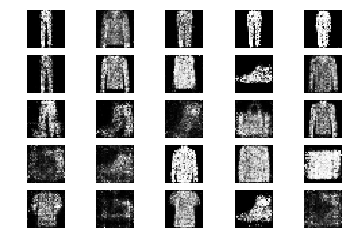

15801 [D loss: 0.628023, acc.: 67.19%] [G loss: 0.937820]
15802 [D loss: 0.649526, acc.: 59.38%] [G loss: 0.954677]
15803 [D loss: 0.715331, acc.: 50.00%] [G loss: 0.939234]
15804 [D loss: 0.673713, acc.: 51.56%] [G loss: 0.983574]
15805 [D loss: 0.594098, acc.: 73.44%] [G loss: 0.907545]
15806 [D loss: 0.592832, acc.: 73.44%] [G loss: 0.984050]
15807 [D loss: 0.707989, acc.: 57.81%] [G loss: 0.954693]
15808 [D loss: 0.626734, acc.: 60.94%] [G loss: 0.928566]
15809 [D loss: 0.664059, acc.: 56.25%] [G loss: 0.942864]
15810 [D loss: 0.687093, acc.: 57.81%] [G loss: 0.968786]
15811 [D loss: 0.687828, acc.: 54.69%] [G loss: 0.946577]
15812 [D loss: 0.622795, acc.: 70.31%] [G loss: 1.013142]
15813 [D loss: 0.624640, acc.: 70.31%] [G loss: 0.992111]
15814 [D loss: 0.667879, acc.: 57.81%] [G loss: 0.951570]
15815 [D loss: 0.596169, acc.: 65.62%] [G loss: 0.926614]
15816 [D loss: 0.636448, acc.: 62.50%] [G loss: 0.909954]
15817 [D loss: 0.653268, acc.: 62.50%] [G loss: 1.004471]
15818 [D loss:

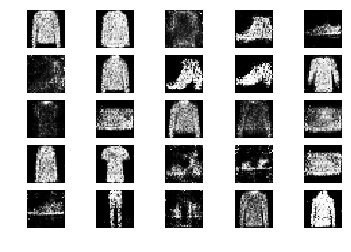

16001 [D loss: 0.627902, acc.: 64.06%] [G loss: 0.882215]
16002 [D loss: 0.640072, acc.: 64.06%] [G loss: 0.860263]
16003 [D loss: 0.706313, acc.: 54.69%] [G loss: 0.876414]
16004 [D loss: 0.660816, acc.: 62.50%] [G loss: 0.880873]
16005 [D loss: 0.641777, acc.: 64.06%] [G loss: 0.984199]
16006 [D loss: 0.652621, acc.: 67.19%] [G loss: 0.955717]
16007 [D loss: 0.653090, acc.: 60.94%] [G loss: 0.928008]
16008 [D loss: 0.621008, acc.: 71.88%] [G loss: 0.826102]
16009 [D loss: 0.662864, acc.: 64.06%] [G loss: 0.889130]
16010 [D loss: 0.640128, acc.: 62.50%] [G loss: 0.894831]
16011 [D loss: 0.642966, acc.: 60.94%] [G loss: 0.934877]
16012 [D loss: 0.611282, acc.: 71.88%] [G loss: 0.986755]
16013 [D loss: 0.648900, acc.: 62.50%] [G loss: 0.896687]
16014 [D loss: 0.654608, acc.: 59.38%] [G loss: 0.868710]
16015 [D loss: 0.610269, acc.: 64.06%] [G loss: 0.816756]
16016 [D loss: 0.593890, acc.: 71.88%] [G loss: 0.901689]
16017 [D loss: 0.625211, acc.: 65.62%] [G loss: 0.938895]
16018 [D loss:

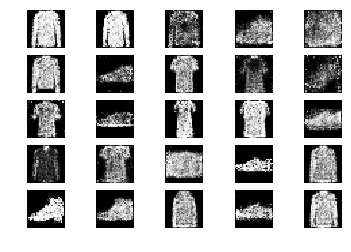

16201 [D loss: 0.626850, acc.: 65.62%] [G loss: 0.913454]
16202 [D loss: 0.700863, acc.: 54.69%] [G loss: 0.823326]
16203 [D loss: 0.636441, acc.: 59.38%] [G loss: 0.897530]
16204 [D loss: 0.677143, acc.: 53.12%] [G loss: 0.841703]
16205 [D loss: 0.665004, acc.: 59.38%] [G loss: 0.827602]
16206 [D loss: 0.715355, acc.: 50.00%] [G loss: 0.931386]
16207 [D loss: 0.640154, acc.: 70.31%] [G loss: 0.857069]
16208 [D loss: 0.606068, acc.: 64.06%] [G loss: 0.924780]
16209 [D loss: 0.613842, acc.: 62.50%] [G loss: 0.950364]
16210 [D loss: 0.615727, acc.: 62.50%] [G loss: 0.920091]
16211 [D loss: 0.653539, acc.: 54.69%] [G loss: 0.933608]
16212 [D loss: 0.678574, acc.: 54.69%] [G loss: 0.953471]
16213 [D loss: 0.661494, acc.: 60.94%] [G loss: 0.825153]
16214 [D loss: 0.656844, acc.: 64.06%] [G loss: 0.931616]
16215 [D loss: 0.662208, acc.: 57.81%] [G loss: 0.987208]
16216 [D loss: 0.693986, acc.: 60.94%] [G loss: 0.852255]
16217 [D loss: 0.659932, acc.: 64.06%] [G loss: 0.875546]
16218 [D loss:

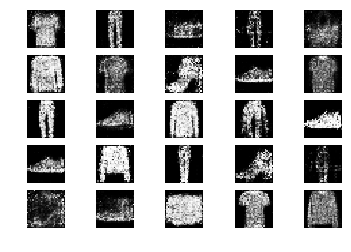

16401 [D loss: 0.713421, acc.: 45.31%] [G loss: 0.914616]
16402 [D loss: 0.635299, acc.: 67.19%] [G loss: 0.883812]
16403 [D loss: 0.620031, acc.: 70.31%] [G loss: 0.923384]
16404 [D loss: 0.657483, acc.: 60.94%] [G loss: 0.779551]
16405 [D loss: 0.661649, acc.: 56.25%] [G loss: 0.861036]
16406 [D loss: 0.686887, acc.: 59.38%] [G loss: 0.844769]
16407 [D loss: 0.621044, acc.: 71.88%] [G loss: 0.964393]
16408 [D loss: 0.648534, acc.: 60.94%] [G loss: 0.911943]
16409 [D loss: 0.670880, acc.: 57.81%] [G loss: 0.835060]
16410 [D loss: 0.651263, acc.: 60.94%] [G loss: 0.911860]
16411 [D loss: 0.631226, acc.: 59.38%] [G loss: 0.945863]
16412 [D loss: 0.656419, acc.: 56.25%] [G loss: 0.898564]
16413 [D loss: 0.670492, acc.: 57.81%] [G loss: 0.899384]
16414 [D loss: 0.625011, acc.: 70.31%] [G loss: 0.897252]
16415 [D loss: 0.663244, acc.: 56.25%] [G loss: 0.800538]
16416 [D loss: 0.586661, acc.: 70.31%] [G loss: 0.915297]
16417 [D loss: 0.643049, acc.: 62.50%] [G loss: 0.970848]
16418 [D loss:

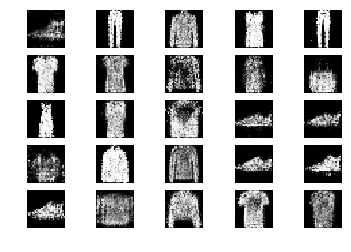

16601 [D loss: 0.597838, acc.: 73.44%] [G loss: 0.958468]
16602 [D loss: 0.597637, acc.: 70.31%] [G loss: 0.947413]
16603 [D loss: 0.638054, acc.: 64.06%] [G loss: 0.908325]
16604 [D loss: 0.682450, acc.: 53.12%] [G loss: 1.004681]
16605 [D loss: 0.620694, acc.: 65.62%] [G loss: 1.004831]
16606 [D loss: 0.647594, acc.: 60.94%] [G loss: 0.875491]
16607 [D loss: 0.646418, acc.: 57.81%] [G loss: 0.881483]
16608 [D loss: 0.643267, acc.: 59.38%] [G loss: 0.903162]
16609 [D loss: 0.679168, acc.: 54.69%] [G loss: 0.954447]
16610 [D loss: 0.660076, acc.: 54.69%] [G loss: 0.935844]
16611 [D loss: 0.663944, acc.: 59.38%] [G loss: 0.908397]
16612 [D loss: 0.654625, acc.: 59.38%] [G loss: 0.856599]
16613 [D loss: 0.602413, acc.: 67.19%] [G loss: 0.939527]
16614 [D loss: 0.702250, acc.: 64.06%] [G loss: 1.001676]
16615 [D loss: 0.559144, acc.: 78.12%] [G loss: 0.978726]
16616 [D loss: 0.627952, acc.: 70.31%] [G loss: 0.850321]
16617 [D loss: 0.635713, acc.: 59.38%] [G loss: 0.973182]
16618 [D loss:

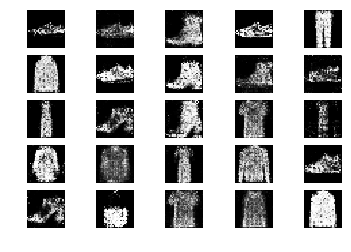

16801 [D loss: 0.699736, acc.: 53.12%] [G loss: 0.980167]
16802 [D loss: 0.634969, acc.: 67.19%] [G loss: 0.979557]
16803 [D loss: 0.611562, acc.: 67.19%] [G loss: 0.897916]
16804 [D loss: 0.719148, acc.: 46.88%] [G loss: 0.926278]
16805 [D loss: 0.621598, acc.: 65.62%] [G loss: 0.971340]
16806 [D loss: 0.696300, acc.: 60.94%] [G loss: 0.876486]
16807 [D loss: 0.710295, acc.: 53.12%] [G loss: 0.971172]
16808 [D loss: 0.615789, acc.: 70.31%] [G loss: 0.951185]
16809 [D loss: 0.758519, acc.: 54.69%] [G loss: 0.913663]
16810 [D loss: 0.657721, acc.: 53.12%] [G loss: 0.849242]
16811 [D loss: 0.698080, acc.: 54.69%] [G loss: 0.875088]
16812 [D loss: 0.604342, acc.: 64.06%] [G loss: 0.899063]
16813 [D loss: 0.601202, acc.: 70.31%] [G loss: 0.921375]
16814 [D loss: 0.660311, acc.: 65.62%] [G loss: 0.960067]
16815 [D loss: 0.634116, acc.: 68.75%] [G loss: 0.939782]
16816 [D loss: 0.694513, acc.: 51.56%] [G loss: 0.948949]
16817 [D loss: 0.639398, acc.: 62.50%] [G loss: 0.957438]
16818 [D loss:

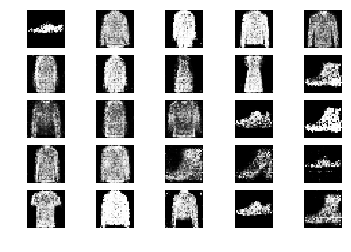

17001 [D loss: 0.615062, acc.: 62.50%] [G loss: 0.909158]
17002 [D loss: 0.653465, acc.: 60.94%] [G loss: 0.960480]
17003 [D loss: 0.672353, acc.: 59.38%] [G loss: 0.931822]
17004 [D loss: 0.621802, acc.: 67.19%] [G loss: 0.857454]
17005 [D loss: 0.661925, acc.: 53.12%] [G loss: 0.949062]
17006 [D loss: 0.615021, acc.: 62.50%] [G loss: 1.017042]
17007 [D loss: 0.713239, acc.: 51.56%] [G loss: 0.966054]
17008 [D loss: 0.607492, acc.: 64.06%] [G loss: 0.967953]
17009 [D loss: 0.638978, acc.: 65.62%] [G loss: 0.882274]
17010 [D loss: 0.615563, acc.: 71.88%] [G loss: 0.805427]
17011 [D loss: 0.688515, acc.: 62.50%] [G loss: 0.833032]
17012 [D loss: 0.639473, acc.: 56.25%] [G loss: 0.850295]
17013 [D loss: 0.645347, acc.: 62.50%] [G loss: 0.941118]
17014 [D loss: 0.640093, acc.: 64.06%] [G loss: 0.984641]
17015 [D loss: 0.669977, acc.: 53.12%] [G loss: 0.862548]
17016 [D loss: 0.650303, acc.: 57.81%] [G loss: 0.943156]
17017 [D loss: 0.625292, acc.: 62.50%] [G loss: 1.011889]
17018 [D loss:

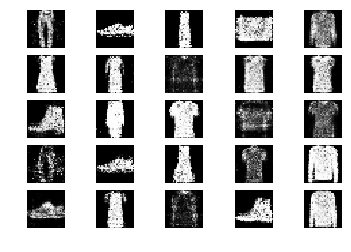

17201 [D loss: 0.643472, acc.: 60.94%] [G loss: 0.899637]
17202 [D loss: 0.643966, acc.: 64.06%] [G loss: 0.938896]
17203 [D loss: 0.703338, acc.: 54.69%] [G loss: 0.931926]
17204 [D loss: 0.685435, acc.: 64.06%] [G loss: 0.947053]
17205 [D loss: 0.682183, acc.: 51.56%] [G loss: 0.961267]
17206 [D loss: 0.646518, acc.: 64.06%] [G loss: 0.914091]
17207 [D loss: 0.721653, acc.: 48.44%] [G loss: 0.952439]
17208 [D loss: 0.673811, acc.: 62.50%] [G loss: 0.913140]
17209 [D loss: 0.574098, acc.: 73.44%] [G loss: 0.949502]
17210 [D loss: 0.612732, acc.: 65.62%] [G loss: 1.047052]
17211 [D loss: 0.713420, acc.: 51.56%] [G loss: 0.891718]
17212 [D loss: 0.649551, acc.: 64.06%] [G loss: 0.935858]
17213 [D loss: 0.666202, acc.: 53.12%] [G loss: 0.938806]
17214 [D loss: 0.678552, acc.: 67.19%] [G loss: 0.967602]
17215 [D loss: 0.669737, acc.: 56.25%] [G loss: 0.884023]
17216 [D loss: 0.630492, acc.: 62.50%] [G loss: 0.948167]
17217 [D loss: 0.696536, acc.: 60.94%] [G loss: 0.963976]
17218 [D loss:

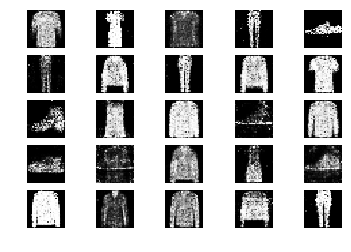

17401 [D loss: 0.629914, acc.: 67.19%] [G loss: 0.974782]
17402 [D loss: 0.675451, acc.: 51.56%] [G loss: 0.923823]
17403 [D loss: 0.638542, acc.: 67.19%] [G loss: 0.826431]
17404 [D loss: 0.612756, acc.: 60.94%] [G loss: 0.945239]
17405 [D loss: 0.661904, acc.: 64.06%] [G loss: 0.909888]
17406 [D loss: 0.688528, acc.: 60.94%] [G loss: 0.951386]
17407 [D loss: 0.642428, acc.: 59.38%] [G loss: 0.920311]
17408 [D loss: 0.664950, acc.: 65.62%] [G loss: 0.975174]
17409 [D loss: 0.674637, acc.: 54.69%] [G loss: 0.870375]
17410 [D loss: 0.756259, acc.: 45.31%] [G loss: 0.968941]
17411 [D loss: 0.623809, acc.: 62.50%] [G loss: 1.031138]
17412 [D loss: 0.639487, acc.: 68.75%] [G loss: 0.924939]
17413 [D loss: 0.688675, acc.: 59.38%] [G loss: 0.856370]
17414 [D loss: 0.703907, acc.: 54.69%] [G loss: 0.896591]
17415 [D loss: 0.665783, acc.: 60.94%] [G loss: 0.998437]
17416 [D loss: 0.668358, acc.: 62.50%] [G loss: 0.948135]
17417 [D loss: 0.683697, acc.: 53.12%] [G loss: 0.999035]
17418 [D loss:

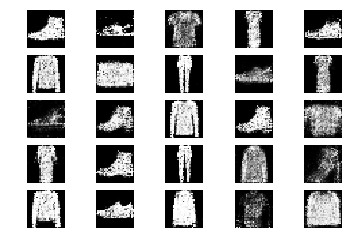

17601 [D loss: 0.611079, acc.: 64.06%] [G loss: 1.007931]
17602 [D loss: 0.700200, acc.: 62.50%] [G loss: 0.952818]
17603 [D loss: 0.681650, acc.: 56.25%] [G loss: 0.865694]
17604 [D loss: 0.631316, acc.: 65.62%] [G loss: 0.888811]
17605 [D loss: 0.593046, acc.: 67.19%] [G loss: 0.956362]
17606 [D loss: 0.677265, acc.: 60.94%] [G loss: 0.900590]
17607 [D loss: 0.639575, acc.: 70.31%] [G loss: 0.973675]
17608 [D loss: 0.700351, acc.: 51.56%] [G loss: 0.939666]
17609 [D loss: 0.640430, acc.: 64.06%] [G loss: 0.914517]
17610 [D loss: 0.635287, acc.: 67.19%] [G loss: 0.892468]
17611 [D loss: 0.603495, acc.: 73.44%] [G loss: 0.927103]
17612 [D loss: 0.652634, acc.: 57.81%] [G loss: 0.919678]
17613 [D loss: 0.632731, acc.: 59.38%] [G loss: 0.856875]
17614 [D loss: 0.677360, acc.: 53.12%] [G loss: 0.835263]
17615 [D loss: 0.666993, acc.: 60.94%] [G loss: 0.972656]
17616 [D loss: 0.654957, acc.: 62.50%] [G loss: 0.875332]
17617 [D loss: 0.635423, acc.: 62.50%] [G loss: 0.869606]
17618 [D loss:

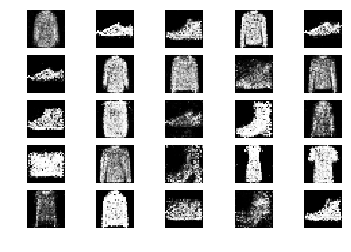

17801 [D loss: 0.663353, acc.: 62.50%] [G loss: 0.883039]
17802 [D loss: 0.612297, acc.: 75.00%] [G loss: 0.866920]
17803 [D loss: 0.681396, acc.: 56.25%] [G loss: 0.943713]
17804 [D loss: 0.639098, acc.: 65.62%] [G loss: 0.932125]
17805 [D loss: 0.722209, acc.: 48.44%] [G loss: 0.846326]
17806 [D loss: 0.647786, acc.: 59.38%] [G loss: 0.871992]
17807 [D loss: 0.679633, acc.: 46.88%] [G loss: 0.883573]
17808 [D loss: 0.611898, acc.: 59.38%] [G loss: 0.887221]
17809 [D loss: 0.683416, acc.: 51.56%] [G loss: 0.926800]
17810 [D loss: 0.645245, acc.: 60.94%] [G loss: 0.982423]
17811 [D loss: 0.633833, acc.: 62.50%] [G loss: 0.917299]
17812 [D loss: 0.707581, acc.: 40.62%] [G loss: 0.924333]
17813 [D loss: 0.641434, acc.: 59.38%] [G loss: 0.920554]
17814 [D loss: 0.600589, acc.: 71.88%] [G loss: 0.899225]
17815 [D loss: 0.633870, acc.: 60.94%] [G loss: 0.908325]
17816 [D loss: 0.634347, acc.: 59.38%] [G loss: 0.935079]
17817 [D loss: 0.652037, acc.: 67.19%] [G loss: 0.951008]
17818 [D loss:

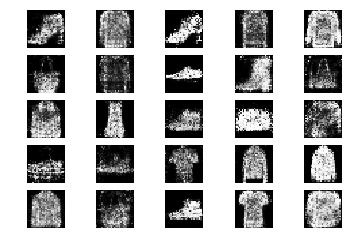

18001 [D loss: 0.633847, acc.: 67.19%] [G loss: 0.903121]
18002 [D loss: 0.665135, acc.: 59.38%] [G loss: 0.964933]
18003 [D loss: 0.622299, acc.: 67.19%] [G loss: 0.921118]
18004 [D loss: 0.626042, acc.: 62.50%] [G loss: 0.914554]
18005 [D loss: 0.628741, acc.: 59.38%] [G loss: 0.962655]
18006 [D loss: 0.590381, acc.: 70.31%] [G loss: 0.920424]
18007 [D loss: 0.697282, acc.: 57.81%] [G loss: 0.995392]
18008 [D loss: 0.642631, acc.: 59.38%] [G loss: 0.947735]
18009 [D loss: 0.680026, acc.: 56.25%] [G loss: 0.847192]
18010 [D loss: 0.575974, acc.: 71.88%] [G loss: 1.016141]
18011 [D loss: 0.649392, acc.: 65.62%] [G loss: 0.959859]
18012 [D loss: 0.666142, acc.: 59.38%] [G loss: 0.991176]
18013 [D loss: 0.773472, acc.: 45.31%] [G loss: 0.996808]
18014 [D loss: 0.619445, acc.: 65.62%] [G loss: 0.905811]
18015 [D loss: 0.661861, acc.: 57.81%] [G loss: 0.921688]
18016 [D loss: 0.618478, acc.: 68.75%] [G loss: 0.892705]
18017 [D loss: 0.711027, acc.: 60.94%] [G loss: 0.891873]
18018 [D loss:

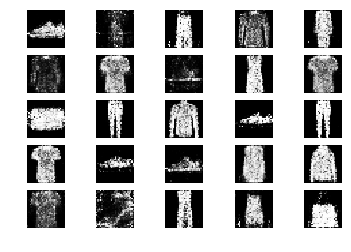

18201 [D loss: 0.692194, acc.: 54.69%] [G loss: 0.960473]
18202 [D loss: 0.665987, acc.: 64.06%] [G loss: 0.983665]
18203 [D loss: 0.641993, acc.: 68.75%] [G loss: 0.956142]
18204 [D loss: 0.643555, acc.: 65.62%] [G loss: 0.977946]
18205 [D loss: 0.616136, acc.: 59.38%] [G loss: 0.975869]
18206 [D loss: 0.634929, acc.: 65.62%] [G loss: 0.985198]
18207 [D loss: 0.670808, acc.: 64.06%] [G loss: 0.913618]
18208 [D loss: 0.643147, acc.: 65.62%] [G loss: 0.831033]
18209 [D loss: 0.681103, acc.: 65.62%] [G loss: 0.917463]
18210 [D loss: 0.639041, acc.: 67.19%] [G loss: 0.975094]
18211 [D loss: 0.697786, acc.: 59.38%] [G loss: 0.936792]
18212 [D loss: 0.658887, acc.: 53.12%] [G loss: 0.873304]
18213 [D loss: 0.620484, acc.: 73.44%] [G loss: 0.882884]
18214 [D loss: 0.627292, acc.: 67.19%] [G loss: 0.833038]
18215 [D loss: 0.670099, acc.: 59.38%] [G loss: 0.839863]
18216 [D loss: 0.679345, acc.: 56.25%] [G loss: 0.892726]
18217 [D loss: 0.591891, acc.: 73.44%] [G loss: 0.912759]
18218 [D loss:

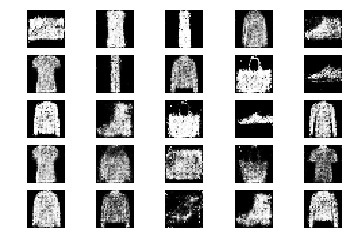

18401 [D loss: 0.628190, acc.: 62.50%] [G loss: 1.008029]
18402 [D loss: 0.662279, acc.: 57.81%] [G loss: 0.936581]
18403 [D loss: 0.624058, acc.: 71.88%] [G loss: 0.830721]
18404 [D loss: 0.677541, acc.: 54.69%] [G loss: 0.794372]
18405 [D loss: 0.712537, acc.: 57.81%] [G loss: 0.988213]
18406 [D loss: 0.656035, acc.: 60.94%] [G loss: 0.860907]
18407 [D loss: 0.619087, acc.: 70.31%] [G loss: 0.990991]
18408 [D loss: 0.619168, acc.: 71.88%] [G loss: 0.941108]
18409 [D loss: 0.709108, acc.: 50.00%] [G loss: 0.920572]
18410 [D loss: 0.694621, acc.: 59.38%] [G loss: 0.927897]
18411 [D loss: 0.645642, acc.: 59.38%] [G loss: 0.835413]
18412 [D loss: 0.602381, acc.: 67.19%] [G loss: 0.880485]
18413 [D loss: 0.683161, acc.: 57.81%] [G loss: 0.902202]
18414 [D loss: 0.643438, acc.: 60.94%] [G loss: 0.902964]
18415 [D loss: 0.658637, acc.: 67.19%] [G loss: 0.963580]
18416 [D loss: 0.690730, acc.: 60.94%] [G loss: 0.914578]
18417 [D loss: 0.634304, acc.: 68.75%] [G loss: 0.965061]
18418 [D loss:

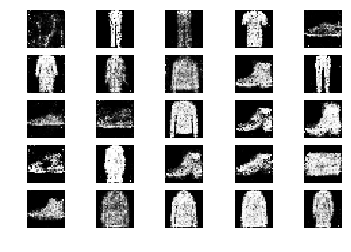

18601 [D loss: 0.578605, acc.: 79.69%] [G loss: 0.959372]
18602 [D loss: 0.638848, acc.: 56.25%] [G loss: 0.959653]
18603 [D loss: 0.700966, acc.: 54.69%] [G loss: 1.005461]
18604 [D loss: 0.671369, acc.: 56.25%] [G loss: 0.938463]
18605 [D loss: 0.564938, acc.: 75.00%] [G loss: 0.817408]
18606 [D loss: 0.663775, acc.: 57.81%] [G loss: 0.860465]
18607 [D loss: 0.682053, acc.: 60.94%] [G loss: 0.855593]
18608 [D loss: 0.643732, acc.: 54.69%] [G loss: 0.916014]
18609 [D loss: 0.642879, acc.: 64.06%] [G loss: 0.897588]
18610 [D loss: 0.645847, acc.: 57.81%] [G loss: 0.942793]
18611 [D loss: 0.637839, acc.: 65.62%] [G loss: 0.889917]
18612 [D loss: 0.635424, acc.: 62.50%] [G loss: 0.974578]
18613 [D loss: 0.608955, acc.: 68.75%] [G loss: 0.993578]
18614 [D loss: 0.777480, acc.: 48.44%] [G loss: 0.872309]
18615 [D loss: 0.671404, acc.: 62.50%] [G loss: 0.868898]
18616 [D loss: 0.610957, acc.: 75.00%] [G loss: 0.878395]
18617 [D loss: 0.637392, acc.: 64.06%] [G loss: 0.874266]
18618 [D loss:

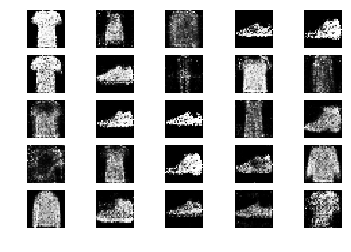

18801 [D loss: 0.655683, acc.: 59.38%] [G loss: 0.958502]
18802 [D loss: 0.591510, acc.: 73.44%] [G loss: 1.011485]
18803 [D loss: 0.681915, acc.: 51.56%] [G loss: 0.976861]
18804 [D loss: 0.694778, acc.: 56.25%] [G loss: 0.882783]
18805 [D loss: 0.731777, acc.: 46.88%] [G loss: 0.901204]
18806 [D loss: 0.675998, acc.: 54.69%] [G loss: 0.797750]
18807 [D loss: 0.716691, acc.: 56.25%] [G loss: 0.888168]
18808 [D loss: 0.569241, acc.: 76.56%] [G loss: 0.860076]
18809 [D loss: 0.642672, acc.: 64.06%] [G loss: 0.845381]
18810 [D loss: 0.660879, acc.: 59.38%] [G loss: 0.913694]
18811 [D loss: 0.687980, acc.: 56.25%] [G loss: 0.973336]
18812 [D loss: 0.674958, acc.: 59.38%] [G loss: 0.986951]
18813 [D loss: 0.635255, acc.: 64.06%] [G loss: 0.885613]
18814 [D loss: 0.652651, acc.: 60.94%] [G loss: 0.873967]
18815 [D loss: 0.610639, acc.: 70.31%] [G loss: 0.874925]
18816 [D loss: 0.645940, acc.: 56.25%] [G loss: 0.838979]
18817 [D loss: 0.656080, acc.: 62.50%] [G loss: 0.909338]
18818 [D loss:

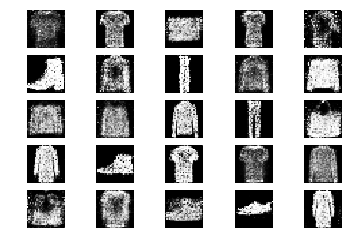

19001 [D loss: 0.663829, acc.: 62.50%] [G loss: 0.931619]
19002 [D loss: 0.651167, acc.: 60.94%] [G loss: 1.019343]
19003 [D loss: 0.644825, acc.: 62.50%] [G loss: 0.927122]
19004 [D loss: 0.638862, acc.: 62.50%] [G loss: 0.963185]
19005 [D loss: 0.577314, acc.: 71.88%] [G loss: 1.023031]
19006 [D loss: 0.584860, acc.: 71.88%] [G loss: 0.864554]
19007 [D loss: 0.609192, acc.: 68.75%] [G loss: 0.957194]
19008 [D loss: 0.660216, acc.: 60.94%] [G loss: 0.875078]
19009 [D loss: 0.626216, acc.: 64.06%] [G loss: 0.942914]
19010 [D loss: 0.734441, acc.: 46.88%] [G loss: 0.911050]
19011 [D loss: 0.697859, acc.: 57.81%] [G loss: 0.804955]
19012 [D loss: 0.597846, acc.: 71.88%] [G loss: 0.963815]
19013 [D loss: 0.577934, acc.: 73.44%] [G loss: 0.907499]
19014 [D loss: 0.707488, acc.: 54.69%] [G loss: 0.929037]
19015 [D loss: 0.635706, acc.: 70.31%] [G loss: 0.952919]
19016 [D loss: 0.636912, acc.: 57.81%] [G loss: 0.928971]
19017 [D loss: 0.603606, acc.: 70.31%] [G loss: 0.949415]
19018 [D loss:

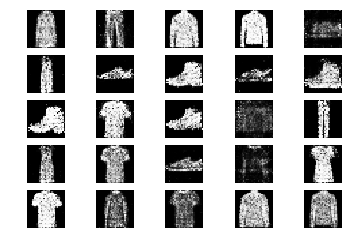

19201 [D loss: 0.591436, acc.: 70.31%] [G loss: 0.835103]
19202 [D loss: 0.658597, acc.: 56.25%] [G loss: 0.949652]
19203 [D loss: 0.657789, acc.: 62.50%] [G loss: 0.807955]
19204 [D loss: 0.626464, acc.: 64.06%] [G loss: 0.879125]
19205 [D loss: 0.618889, acc.: 71.88%] [G loss: 0.795592]
19206 [D loss: 0.629453, acc.: 67.19%] [G loss: 0.896227]
19207 [D loss: 0.629087, acc.: 62.50%] [G loss: 0.852320]
19208 [D loss: 0.616026, acc.: 70.31%] [G loss: 0.906907]
19209 [D loss: 0.654249, acc.: 57.81%] [G loss: 0.964540]
19210 [D loss: 0.656138, acc.: 59.38%] [G loss: 0.924641]
19211 [D loss: 0.622788, acc.: 70.31%] [G loss: 0.986128]
19212 [D loss: 0.664966, acc.: 60.94%] [G loss: 0.927692]
19213 [D loss: 0.711397, acc.: 54.69%] [G loss: 0.789182]
19214 [D loss: 0.694590, acc.: 60.94%] [G loss: 0.918895]
19215 [D loss: 0.598091, acc.: 71.88%] [G loss: 0.904262]
19216 [D loss: 0.608458, acc.: 70.31%] [G loss: 0.876939]
19217 [D loss: 0.626922, acc.: 67.19%] [G loss: 0.832458]
19218 [D loss:

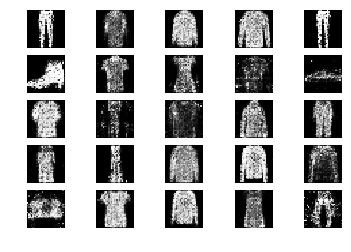

19401 [D loss: 0.606526, acc.: 62.50%] [G loss: 0.920285]
19402 [D loss: 0.696893, acc.: 59.38%] [G loss: 0.810915]
19403 [D loss: 0.686095, acc.: 53.12%] [G loss: 0.888637]
19404 [D loss: 0.627490, acc.: 67.19%] [G loss: 0.997638]
19405 [D loss: 0.649501, acc.: 67.19%] [G loss: 0.925171]
19406 [D loss: 0.637982, acc.: 60.94%] [G loss: 0.967748]
19407 [D loss: 0.711151, acc.: 56.25%] [G loss: 0.930294]
19408 [D loss: 0.648131, acc.: 64.06%] [G loss: 0.921383]
19409 [D loss: 0.625199, acc.: 60.94%] [G loss: 0.899728]
19410 [D loss: 0.657534, acc.: 62.50%] [G loss: 1.010362]
19411 [D loss: 0.702492, acc.: 50.00%] [G loss: 0.909990]
19412 [D loss: 0.622966, acc.: 60.94%] [G loss: 0.886423]
19413 [D loss: 0.672542, acc.: 56.25%] [G loss: 0.840330]
19414 [D loss: 0.653326, acc.: 57.81%] [G loss: 0.809805]
19415 [D loss: 0.648066, acc.: 59.38%] [G loss: 0.841009]
19416 [D loss: 0.674362, acc.: 65.62%] [G loss: 0.921398]
19417 [D loss: 0.634200, acc.: 62.50%] [G loss: 0.943517]
19418 [D loss:

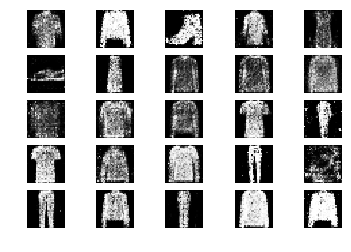

19601 [D loss: 0.703903, acc.: 59.38%] [G loss: 0.855366]
19602 [D loss: 0.591160, acc.: 71.88%] [G loss: 0.936772]
19603 [D loss: 0.625266, acc.: 68.75%] [G loss: 0.879064]
19604 [D loss: 0.632553, acc.: 70.31%] [G loss: 0.886010]
19605 [D loss: 0.738501, acc.: 53.12%] [G loss: 1.000390]
19606 [D loss: 0.692069, acc.: 56.25%] [G loss: 0.946848]
19607 [D loss: 0.729049, acc.: 56.25%] [G loss: 0.887378]
19608 [D loss: 0.657413, acc.: 65.62%] [G loss: 0.898562]
19609 [D loss: 0.595760, acc.: 67.19%] [G loss: 0.874120]
19610 [D loss: 0.618619, acc.: 64.06%] [G loss: 0.917457]
19611 [D loss: 0.616790, acc.: 70.31%] [G loss: 0.840103]
19612 [D loss: 0.639284, acc.: 70.31%] [G loss: 0.846908]
19613 [D loss: 0.685304, acc.: 50.00%] [G loss: 0.898224]
19614 [D loss: 0.634471, acc.: 64.06%] [G loss: 0.904619]
19615 [D loss: 0.583339, acc.: 75.00%] [G loss: 0.901835]
19616 [D loss: 0.670546, acc.: 60.94%] [G loss: 0.976564]
19617 [D loss: 0.621635, acc.: 62.50%] [G loss: 0.978850]
19618 [D loss:

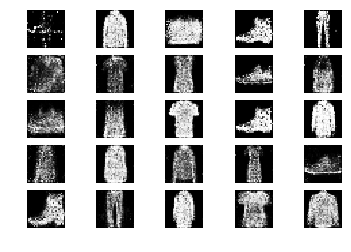

19801 [D loss: 0.655975, acc.: 64.06%] [G loss: 1.025637]
19802 [D loss: 0.660578, acc.: 54.69%] [G loss: 0.960012]
19803 [D loss: 0.656056, acc.: 65.62%] [G loss: 0.990873]
19804 [D loss: 0.669238, acc.: 60.94%] [G loss: 0.958308]
19805 [D loss: 0.676977, acc.: 60.94%] [G loss: 0.937061]
19806 [D loss: 0.638086, acc.: 68.75%] [G loss: 0.912835]
19807 [D loss: 0.665958, acc.: 59.38%] [G loss: 1.026244]
19808 [D loss: 0.646734, acc.: 60.94%] [G loss: 0.998835]
19809 [D loss: 0.577790, acc.: 70.31%] [G loss: 0.960480]
19810 [D loss: 0.717588, acc.: 50.00%] [G loss: 0.997413]
19811 [D loss: 0.653407, acc.: 60.94%] [G loss: 0.944843]
19812 [D loss: 0.638719, acc.: 64.06%] [G loss: 0.905083]
19813 [D loss: 0.730533, acc.: 48.44%] [G loss: 0.922669]
19814 [D loss: 0.616380, acc.: 68.75%] [G loss: 1.008491]
19815 [D loss: 0.631437, acc.: 67.19%] [G loss: 0.850765]
19816 [D loss: 0.613548, acc.: 60.94%] [G loss: 0.780084]
19817 [D loss: 0.650590, acc.: 59.38%] [G loss: 0.844368]
19818 [D loss:

In [5]:
gan.train(epochs=20000, batch_size=32, sample_interval=200)

## New Images View

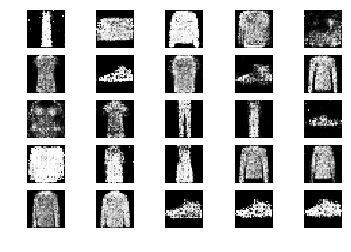

In [7]:
gan.sample_images(20000)